# 0. Introduction

### Getting Started 
1. Go to https://liveuclac-my.sharepoint.com/:f:/g/personal/ucacsb0_ucl_ac_uk/EoXnsBp6YW5DtowaQtHNq68BufmeaIlo_-iHm1yVyQ54EA?e=Q6w0AZ  and download the 10 level data for Amazon and Microsoft
2. Save in a folder named 'data' where this file is saved.


### Data & Book
You can download the book **"Trades, Quotes and Prices"** by logging into Cambridge Univ. Press with your UCL credentials.
https://www.cambridge.org/core/books/trades-quotes-and-prices/029A71078EE4C41C0D5D4574211AB1B5
In the preface you can find the password to download a snapshot of the LOB for free: https://lobsterdata.com/

**Other data sources:**
 - Sample single stocks: data https://lobsterdata.com/info/DataSamples.php
 - 1 level LOB data: https://www.dukascopy.com/trading-tools/widgets/quotes/historical_data_feed
  - Crypto: https://github.com/ccxt 


## Limit Order Book (LOB) — Simplified Analysis

**Goal:** Provide a clear, minimal, and well-documented workflow to analyse a Limit Order Book (LOB) without changing either (i) how libraries are imported or (ii) how the data path is referenced in your original notebook.

> This notebook is written to **drop in** alongside your existing code. If you already load dataframes or set path variables in your environment, this notebook will **detect and reuse** them.  
> If nothing is loaded yet, it will **try to read** the standard LOBSTER-like files using variables that many notebooks already define (e.g., `MSG_FILE`, `OB_FILE`).

We implement the following:
1. **Bid–Ask Spread**
   - Plot spread as a time series
   - Resample spread at **1-minute**
   - Histogram of spread values
   - Average spread over (i) **full trading day**, and (ii) events **between 11:00 and 13:00**
2. **Depth at Best Bid/Ask**  
   - Time series plots  
   - 1-minute resampling  
   - Average depth over full trading day  
   - **Mid-price**: time series and 1-minute resample
3. **Order Size Distributions**
   - For **Type 1** (limit order submissions)
   - For **Type 4/5** (visible/hidden executions; “visible/invisible market orders”)
   - Histograms; optional **log–log** view

---

### Assumptions & Conventions
- **Messages file** columns (LOBSTER-style):  
  `Time, Type, OrderID, Size, Price, Direction`  
  where `Time` is seconds since midnight (float), `Price` is in **price * 10,000** units.
- **Order book (OB) file** has interleaved columns for the *top N levels*:  
  `ask_p1, ask_s1, bid_p1, bid_s1, ask_p2, ask_s2, bid_p2, bid_s2, ...`
- **Scaling**: Prices divided by **10,000** to get natural units; spreads and mid-prices shown in the same units as price.
- **Indexing**: We align the **order book rows** to the **messages timestamps** (they should have equal length and correspond one-to-one).

If your files differ, you can tweak the small parsing helpers below — but the import style and your path variables are left untouched.


## Message file information:
----------------------------------------------------------

- Dimension - NumberEvents x 6
- Structure - Each row:
    - Time stamp (sec after midnight with decimal precision of at least milliseconds and up to nanoseconds depending on the period)
    - Event type
    - Order ID
    - Size (# of shares)
    - Price
    - Direction


Event types:
- '1'   Submission new limit order
- '2'   Cancellation (partial)
- '3'   Deletion (total order)
- '4'   Execution of a visible limit order
- '5'   Execution of a hidden limit order
- '7'   Trading Halt (Detailed information below)

Direction:
- '-1'  Sell limit order
- '1'  Buy limit order
- NOTE: Execution of a sell (buy) limit order corresponds to a buyer-(seller-) initiated trade, i.e. a BUY (SELL) trade.

----------------------------------------------------------


## 1. Set things up & load data

### Import the necessary libraries and print version numbers

In [1]:
# standard OS functions
import os
# just to check version number
from platform import python_version
print('Running Python version ' + python_version())


# Import each library, if not found, prompt installation
try:
    import pandas as pd  # Data wrangling 
    print('Running Pandas version ' + pd.__version__)
except:
    print('Pandas not installed, check installation in you active environment, and if not, use pip to install')
    
try:
    import matplotlib as mpl  # Plotting
    print('Running MatPlotLib version ' + mpl.__version__)
    from matplotlib import pyplot as plt
    from matplotlib.dates import DateFormatter, MinuteLocator
except:
    print('MatPlotLib not installed, check installation in you active environment, and if not, use pip to install')
    
try:
    import numpy as np  # Vector manipulation
    print('Running Numpy version ' + np.__version__)
except:
    print('Numpy not installed, check installation in you active environment, and if not, use pip to install')

try:
    import seaborn as sns # Enhanced plotting
    print('Running SeaBorn version ' + sns.__version__)
except:
    print('err')


# Display utilities
from IPython.display import display, Markdown   # Allows text between plots

Running Python version 3.11.13
Running Pandas version 2.3.3
Running MatPlotLib version 3.10.7
Running Numpy version 2.3.4
Running SeaBorn version 0.13.2


### Set up paths data file import

In [2]:
# get the current directory (CWD) for use defining path to data
cwd=os.getcwd()
print('Current directory: '+cwd)

if os.path.isdir(os.path.join(cwd,"data")):
    DATA_DIR=os.path.join(cwd,"data")
else:
    print('Set data path manually')
    DATA_DIR='/Users/Stephen/Documents/University & Courses/UCL/TA Work/2025/COMP0049/Demos & Code/Lab1 SL/data'
print('Data directory ' + DATA_DIR + ' present') if os.path.isdir(DATA_DIR) else print('Data directory ' + DATA_DIR + ' absent!\nCheck path')

# --- Filenames from your original notebook ---
MESSAGE_FILE_TAIL = "_2012-06-21_34200000_57600000_message_10.csv"
ORDERBOOK_FILE_TAIL = "_2012-06-21_34200000_57600000_orderbook_10.csv"

#
MESSAGE_COL_NAMES = ['Time','Type','OrderID','Size','Price','TradeDirection']
OB_COL_NAMES = ['Ask Price ','Ask Size ','Bid Price ','Bid Size ']

# Map numeric Type -> description (adjust if your codes differ)
TYPE_MAP = {
    1: 'New LO',
    2: 'Cancel',
    3: 'Deletion',
    4: 'Execution visible',
    5: 'Execution hidden',
}


Current directory: /Users/Stephen/Documents/University & Courses/UCL/TA Work/2025/COMP0049/Demos & Code/Lab1 - 17-10-2025
Data directory /Users/Stephen/Documents/University & Courses/UCL/TA Work/2025/COMP0049/Demos & Code/Lab1 - 17-10-2025/data present


### Variables specifying trade data

In [3]:
tickers = ["AMZN", "MSFT"]

#The time component in the data is recorded in seconds after midnight.
startTrad = 9.5*60*60       # 9:30:00.000 in s after midnight
endTrad = 16*60*60          # 16:00:00.000 in s after midnight

tradingDate = "2012-06-21"

### Load the data using Pandas; filters for messages sent between 0930 and 1600.

In [4]:
def load_message_data(ticker, tradingDate=None, startTrad=startTrad, endTrad=endTrad):
    """
    Loads, filters and indexes trade message data for given ticker
    """
    # create message file name from ticker
    msg_file = os.path.join(DATA_DIR, f"{ticker}{MESSAGE_FILE_TAIL}")

    # Load trading message data from CWV
    # Note, correct column ordering is assumed
    msgBook = pd.read_csv(msg_file, names = MESSAGE_COL_NAMES)

    # create a new data column with values equal to to the row index values
    msgBook['row_index'] = msgBook.index.values

    # Filter to remove any messages outside the trading day
    msgBook = msgBook[msgBook['Time'] >= startTrad]
    msgBook = msgBook[msgBook['Time'] <= endTrad]

    # Create a new column consisting of the true time (date + time)
    # If the actual date is provided, use this, otherwise default date is 1-Jan-1970
    if tradingDate is not None:
        msgBook['DateTime'] = pd.to_datetime(tradingDate) + pd.to_timedelta(msgBook.Time, unit='s')
    else:
        msgBook['DateTime'] = pd.to_datetime(msgBook.Time,unit='s')

    msgBook = msgBook.set_index('DateTime')

    return msgBook


# Create a dictionary of message books by calling loader for each ticker in tickers list
msgBooks = {t: load_message_data(t, tradingDate, startTrad, endTrad) for t in tickers}


## 2. Have a look at the data in the files

### Check dataframe column names

In [5]:
print(msgBooks["AMZN"].columns)
print(msgBooks["MSFT"].columns)

Index(['Time', 'Type', 'OrderID', 'Size', 'Price', 'TradeDirection',
       'row_index'],
      dtype='object')
Index(['Time', 'Type', 'OrderID', 'Size', 'Price', 'TradeDirection',
       'row_index'],
      dtype='object')


### Check it's done what it should do by printing the first and last rows of the dataframe.

In [6]:
display(msgBooks["AMZN"].head())
display(msgBooks["MSFT"].tail())

,Time,Type,OrderID,Size,Price,TradeDirection,row_index
DateTime,,,,,,,
2012-06-21 09:30:00.017459617,34200.017460,5,0,1,2238200,-1,0
2012-06-21 09:30:00.189607670,34200.189608,1,11885113,21,2238100,1,1
2012-06-21 09:30:00.189607670,34200.189608,1,3911376,20,2239600,-1,2
2012-06-21 09:30:00.189607670,34200.189608,1,11534792,100,2237500,1,3
2012-06-21 09:30:00.189607670,34200.189608,1,1365373,13,2240000,-1,4


,Time,Type,OrderID,Size,Price,TradeDirection,row_index
DateTime,,,,,,,
2012-06-21 15:59:59.861465727,57599.861466,3,287081309,9249,301400,-1,668760
2012-06-21 15:59:59.861566671,57599.861567,3,287117122,783,301400,-1,668761
2012-06-21 15:59:59.873177404,57599.873177,3,287070525,800,301500,-1,668762
2012-06-21 15:59:59.907796528,57599.907797,5,0,100,301350,-1,668763
2012-06-21 15:59:59.907796528,57599.907797,5,0,300,301350,-1,668764


### What temporal precision is the data?

In [7]:
# Extract the decimal seconds part by splitting at the . and counting the number of figures after it
decimals = msgBooks["MSFT"]['Time'].astype(str).str.split('.').str[1].str.len()
# Print the smallest power of 10
min_power = 10.0 ** (-decimals.max())
print(f"Smallest temporal precision: {min_power} seconds")

# Count the number of messages at each level of precision
counts = decimals.fillna(0).astype(int).value_counts().sort_index()
print(counts) # Optional, print count by number of dp
print(f"The most common number of decimal places is: {counts.idxmax()}")
print(f"i.e. 10^-{counts.idxmax()} seconds")

Smallest temporal precision: 1e-12 seconds
Time
4         10
5         42
6        615
7       6051
8      59738
9     602307
11         1
12         1
Name: count, dtype: int64
The most common number of decimal places is: 9
i.e. 10^-9 seconds


## 3. Calculate some summary message statistics

### Count the number of trade events on this trading day for each of the two stocks

In [8]:
print(f'Microsoft had {msgBooks["MSFT"].shape[0]:,} trade messages on {tradingDate}: {msgBooks["MSFT"].groupby("TradeDirection")["Size"].count()[1]:,} buy and {msgBooks["MSFT"].groupby("TradeDirection")["Size"].count()[-1]:,} sell')
print(f'Amazon had {msgBooks["AMZN"].shape[0]:,} trade messages on {tradingDate}: {msgBooks["AMZN"].groupby("TradeDirection")["Size"].count()[1]:,} buy and {msgBooks["AMZN"].groupby("TradeDirection")["Size"].count()[-1]:,} sell')

Microsoft had 668,765 trade messages on 2012-06-21: 316,222 buy and 352,543 sell
Amazon had 269,748 trade messages on 2012-06-21: 130,344 buy and 139,404 sell


### Calculate the total volume, total buy value, total sell volume

In [9]:
print(f'Microsoft had {msgBooks["MSFT"].Size.sum():,} total volumne on {tradingDate}: {msgBooks["MSFT"].groupby("TradeDirection")["Size"].sum()[1]:,} buy and {msgBooks["MSFT"].groupby("TradeDirection")["Size"].sum()[-1]:,} sell')
print(f'Amazon had {msgBooks["AMZN"].Size.sum():,} total volume on {tradingDate}: {msgBooks["AMZN"].groupby("TradeDirection")["Size"].sum()[1]:,} buy and {msgBooks["AMZN"].groupby("TradeDirection")["Size"].sum()[-1]:,} sell')

Microsoft had 347,108,132 total volumne on 2012-06-21: 168,466,350 buy and 178,641,782 sell
Amazon had 26,130,625 total volume on 2012-06-21: 13,487,862 buy and 12,642,763 sell


### What is the distribution of event types?

This treats all order types equally however, so for example an order submission and an order cancellation or deletion count equally towards the volume

Lets create a 'summary' function that aggregates events by type (cancellations, hidden/visible etc.) by:
1) portion of order counts, and
2) portion of share volume traded.

Where:
- '1'   Submission new limit order
- '2'   Cancellation (partial)
- '3'   Deletion (total order)
- '4'   Execution of a visible limit order
- '5'   Execution of a hidden limit order

What can we observe?

In [10]:
# small function to create a summary
def summary(msg_book):
    summary = msg_book.groupby('Type')['Size'].agg(['count', 'sum'])
    summary = summary / summary.sum()  # proportions remain numeric floats
    summary['description'] = summary.index.map({
        1: 'New LO',
        2: 'Cancel',
        3: 'Deletion',
        4: 'Execution visible',
        5: 'Execution hidden'
    })
    return summary

summaries = {t: summary(msgBooks[t]) for t in tickers}

In [11]:

display(summaries["MSFT"])
display(summaries["AMZN"])

for t in tickers:
    print(t)
    print(summaries[t].to_string(formatters={
        'count': '{:.2%}'.format,
        'sum':   '{:.2%}'.format,
    }))
    print()

,count,sum,description
Type,,,
1,0.492798,0.503541,New LO
2,0.008377,0.006280,Cancel
3,0.448862,0.458995,Deletion
4,0.044557,0.028486,Execution visible
5,0.005407,0.002699,Execution hidden


,count,sum,description
Type,,,
1,0.489175,0.498550,New LO
2,0.010814,0.013223,Cancel
3,0.457679,0.457200,Deletion
4,0.033268,0.023469,Execution visible
5,0.009064,0.007558,Execution hidden


AMZN
      count    sum        description
Type                                 
1    48.92% 49.86%             New LO
2     1.08%  1.32%             Cancel
3    45.77% 45.72%           Deletion
4     3.33%  2.35%  Execution visible
5     0.91%  0.76%   Execution hidden

MSFT
      count    sum        description
Type                                 
1    49.28% 50.35%             New LO
2     0.84%  0.63%             Cancel
3    44.89% 45.90%           Deletion
4     4.46%  2.85%  Execution visible
5     0.54%  0.27%   Execution hidden



### Lets look at order sizes:

Plot histogram of buy and sell order sizes

In [12]:

def _normalize_type_filter(type_filter):
    """
    Accepts int/str or list/tuple of int/str.
    Returns a set of numeric Type codes to keep.
    """
    if type_filter is None:
        return None
    if not isinstance(type_filter, (list, tuple, set)):
        type_filter = [type_filter]
    keep_types = set()
    # Build reverse map for strings -> code
    REV = {v.lower(): k for k, v in TYPE_MAP.items()}
    for tf in type_filter:
        if isinstance(tf, (int, np.integer)):
            keep_types.add(int(tf))
        elif isinstance(tf, str):
            key = tf.strip().lower()
            if key in REV:
                keep_types.add(REV[key])
            else:
                raise ValueError(f"Unknown order type name: {tf!r}. Valid names: {list(TYPE_MAP.values())}")
        else:
            raise TypeError(f"type_filter entries must be int or str, got {type(tf)}")
    return keep_types

def plot_size_histograms(
    msgBooks,
    tickers=None,
    type_filter=None,
    bins=50,
    logx=False,
    logy=False,
    clip_quantile=None,
    sharey=True,
    figsize_scale=5,
):
    """
    Plot overlaid histograms of buy vs sell order sizes for each ticker, side by side.

    Parameters
    ----------
    msgBooks : dict[str, pandas.DataFrame]
        Dict mapping ticker -> DataFrame with at least ['TradeDirection','Size','Type'].
    tickers : list[str] | None
        Which tickers to plot. Defaults to all keys of msgBooks.
    type_filter : int | str | list[int|str] | None
        Filter by order type (e.g., 1 or "New LO"). Accepts multiple.
    bins : int
        Number of bins (for linear scale) or bin count used for log-spaced bins if logx=True.
    logx : bool
        Use logarithmic x-axis (log-spaced bins). Sizes <= 0 are excluded for log x.
    logy : bool
        Use logarithmic y-axis.
    clip_quantile : float | None
        If provided (e.g., 0.995), clip sizes above this quantile (computed per ticker on combined buy+sell).
    sharey : bool
        Share y-axis among subplots.
    figsize_scale : float
        Width scaling per subplot.
    """
    tickers = tickers or list(msgBooks.keys())
    type_codes = _normalize_type_filter(type_filter)

    fig, axes = plt.subplots(
        1, len(tickers),
        figsize=(figsize_scale * len(tickers), 4),
        sharey=sharey,
        constrained_layout=True
    )
    if len(tickers) == 1:
        axes = [axes]

    for ax, t in zip(axes, tickers):
        df = msgBooks[t]

        # Optional filter by Type
        if type_codes is not None:
            df = df[df['Type'].isin(type_codes)]

        # Split buy/sell sizes
        buy  = df.loc[df['TradeDirection'] == 1,  'Size'].astype(float)
        sell = df.loc[df['TradeDirection'] == -1, 'Size'].astype(float)

        # If nothing to plot after filtering
        if buy.empty and sell.empty:
            ax.set_title(f"{t} — no data")
            ax.set_xlabel("Order Size")
            ax.set_ylabel("Frequency")
            continue

        # Optionally clip tails on combined data for nicer scale (linear or log)
        if clip_quantile is not None:
            combined = np.concatenate([buy.values, sell.values]) if not buy.empty and not sell.empty \
                       else (buy.values if not buy.empty else sell.values)
            clip_val = float(np.nanquantile(combined, clip_quantile))
            buy  = np.clip(buy,  0, clip_val)
            sell = np.clip(sell, 0, clip_val)
        else:
            clip_val = None  # just for label text below

        # Choose bins/range
        if logx:
            # Exclude non-positive for log x
            buy_nz  = buy[buy > 0]
            sell_nz = sell[sell > 0]
            if buy_nz.empty and sell_nz.empty:
                ax.set_title(f"{t} — no positive sizes")
                ax.set_xlabel("Order Size")
                ax.set_ylabel("Frequency")
                continue
            lo = float(np.nanmin(np.concatenate([buy_nz.values, sell_nz.values])))
            hi = float(np.nanmax(np.concatenate([buy_nz.values, sell_nz.values])))
            if hi <= lo:
                hi = lo * 10
            log_bins = np.logspace(np.log10(lo), np.log10(hi), bins)
            ax.hist(buy_nz,  bins=log_bins, alpha=0.3, label="Buys")
            ax.hist(sell_nz, bins=log_bins, alpha=0.4, label="Sells")
            ax.set_xscale("log")
            ax.set_xlabel("Order Size (log scale)")
        else:
            combined = np.concatenate([buy.values, sell.values]) if not buy.empty and not sell.empty \
                       else (buy.values if not buy.empty else sell.values)
            lo = float(np.nanmin(combined))
            hi = float(np.nanmax(combined))
            if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
                lo, hi = 0.0, lo + 1.0
            ax.hist(buy,  bins=bins, range=(lo, hi), alpha=0.6, label="Buys")
            ax.hist(sell, bins=bins, range=(lo, hi), alpha=0.6, label="Sells")
            ax.set_xlabel("Order Size")

        if logy:
            ax.set_yscale("log")

        # Title / labels
        if type_codes is None:
            subtitle = ""
        else:
            names = [TYPE_MAP[c] for c in sorted(type_codes)]
            subtitle = " | ".join(names)
        ax.set_title(f"{t}" + (f" — {subtitle}" if subtitle else ""))

        if clip_val is not None:
            ax.set_xlabel(ax.get_xlabel() + f" (clipped ≤ {clip_quantile*100:.1f}th ≈ {clip_val:.0f})")

        if ax is axes[0]:
            ax.set_ylabel("Frequency")
        ax.grid(alpha=0.3, which="both")
        ax.legend()

    plt.suptitle("Buy vs Sell Order Sizes by Ticker", y=1.05, fontsize=12)
    plt.show()


### We can create a histogram of message order size...

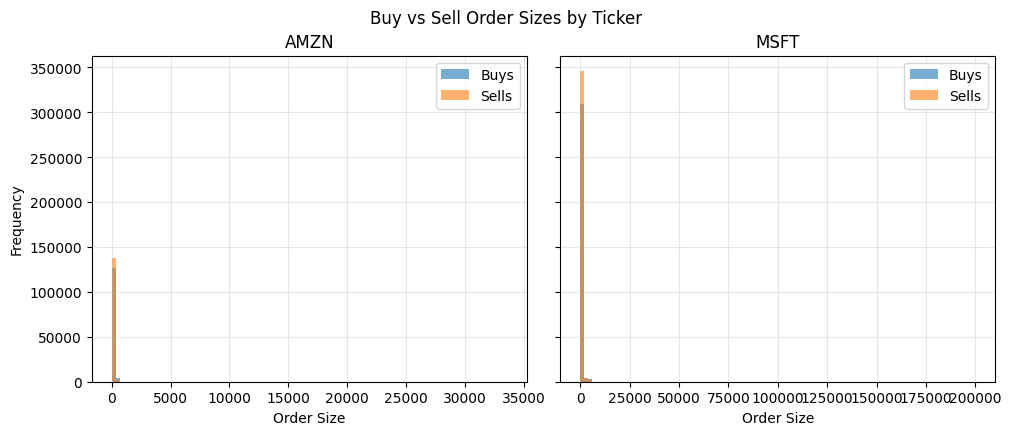

### ...but this includes both new orders and cancelled orders, so lets filter by order type: **New LO (Type = 1)**

### (Easier to see with log y-scale)

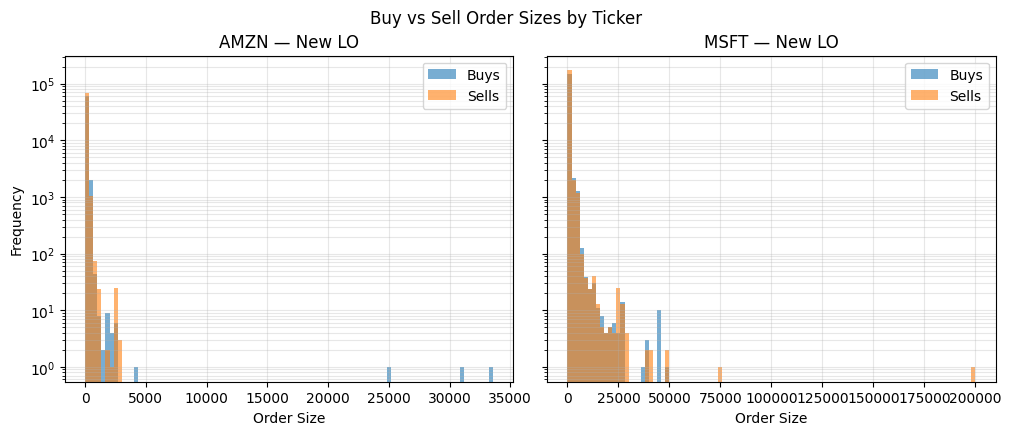

### Skewed by a few larger orders, so lets use log x-scale too

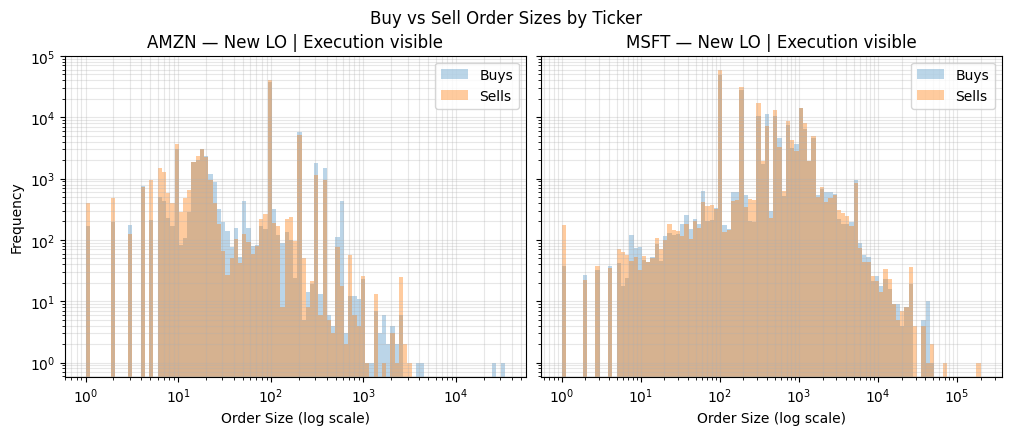

### Or we can clip at a given quantile

### Note peaks at round numbers of shares

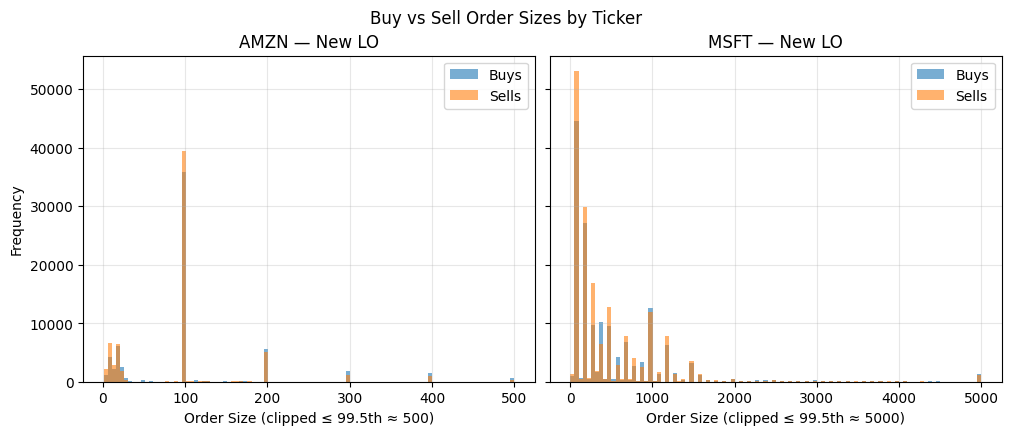

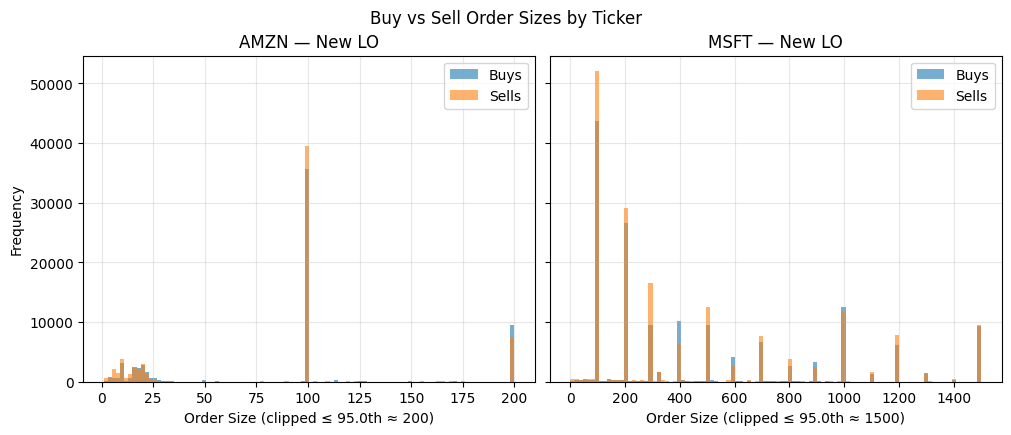

In [13]:
#

display(Markdown("### We can create a histogram of message order size..."))
plot_size_histograms(msgBooks, bins=100)
display(Markdown("### ...but this includes both new orders and cancelled orders, so lets filter by order type: **New LO (Type = 1)**"))
display(Markdown("### (Easier to see with log y-scale)"))
plot_size_histograms(msgBooks, bins=100, type_filter=1, logy=True) # by code, can also filter by name: plot_size_histograms(msgBooks, type_filter="New LO") # by name
display(Markdown("### Skewed by a few larger orders, so lets use log x-scale too"))
plot_size_histograms(
    msgBooks,
    type_filter=[1, 4],   # New LO + Execution visible
    bins=100,
    logx=True,
    logy=True
)
display(Markdown("### Or we can clip at a given quantile"))
display(Markdown("### Note peaks at round numbers of shares"))
plot_size_histograms(msgBooks, bins=100, type_filter="New LO", clip_quantile=0.995) # Clip order size to remove long tail
plot_size_histograms(msgBooks, bins=100, type_filter="New LO", clip_quantile=0.95)


### Lets look at orders placed vs those cancelled or deleted

In [14]:
def _qq_xy(a, b, quantiles=None):
    """Build x/y arrays for a Q–Q plot using a shared quantile grid."""
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    a = a[np.isfinite(a)]
    b = b[np.isfinite(b)]
    if a.size == 0 or b.size == 0:
        return None, None
    q = np.linspace(0.001, 0.999, 499) if quantiles is None else np.asarray(quantiles)
    x = np.quantile(a, q, method="linear")
    y = np.quantile(b, q, method="linear")
    return x, y


def plot_order_volume_qq(
    msgBooks,
    tickers=None,
    clip_quantile=None,  # e.g. 0.999 to trim extreme tails
    logxy=False,         # use log–log scaling
    figsize_scale=5,
    markersize=10,
    linewidth=1.5,
):
    """
    For each ticker: plot Q–Q curves comparing order sizes:
      • Buys:  New LO (Type=1) vs Cancel+Deletion (Types 2,3)
      • Sells: New LO (Type=1) vs Cancel+Deletion (Types 2,3)
    """
    tickers = tickers or list(msgBooks.keys())

    fig, axes = plt.subplots(
        1, len(tickers),
        figsize=(figsize_scale * len(tickers), 5),
        sharey=False,
        constrained_layout=True
    )
    if len(tickers) == 1:
        axes = [axes]

    for ax, t in zip(axes, tickers):
        df = msgBooks[t]

        # Extract buy/sell subsets by type
        buys_new  = df.loc[(df["TradeDirection"] ==  1) & (df["Type"] == 1), "Size"].astype(float)
        buys_cd   = df.loc[(df["TradeDirection"] ==  1) & (df["Type"].isin([2, 3])), "Size"].astype(float)
        sells_new = df.loc[(df["TradeDirection"] == -1) & (df["Type"] == 1), "Size"].astype(float)
        sells_cd  = df.loc[(df["TradeDirection"] == -1) & (df["Type"].isin([2, 3])), "Size"].astype(float)

        # Optional clipping to ignore extreme tails
        if clip_quantile is not None:
            for s in (buys_new, buys_cd, sells_new, sells_cd):
                if not s.empty:
                    cap = float(np.nanquantile(s, clip_quantile))
                    s.clip(upper=cap, inplace=True)

        # Compute quantile-quantile coordinates
        bx, by = _qq_xy(buys_new.values,  buys_cd.values)
        sx, sy = _qq_xy(sells_new.values, sells_cd.values)

        # Skip empty plots
        has_b = bx is not None and by is not None
        has_s = sx is not None and sy is not None
        if not (has_b or has_s):
            ax.set_title(f"{t} — no data")
            ax.set_xlabel("New LO size quantiles")
            ax.set_ylabel("Cancel+Deletion size quantiles")
            continue

        # Axis limits from combined data
        allx = np.concatenate([bx, sx]) if has_b and has_s else (bx if has_b else sx)
        ally = np.concatenate([by, sy]) if has_b and has_s else (by if has_b else sy)
        lim_min = min(np.min(allx), np.min(ally))
        lim_max = max(np.max(allx), np.max(ally))
        if lim_max <= lim_min:
            lim_max = lim_min + 1.0

        # Plot Q–Q curves
        if has_b:
            ax.plot(bx, by, '-', lw=linewidth, label="Buys")
            ax.plot(bx, by, 'o', ms=markersize*0.5, alpha=0.6)
        if has_s:
            ax.plot(sx, sy, '-', lw=linewidth, label="Sells")
            ax.plot(sx, sy, 's', ms=markersize*0.5, alpha=0.6)

        # Reference 45° line
        ax.plot([lim_min, lim_max], [lim_min, lim_max], '--', color='gray', lw=1, label="y = x")

        # Scaling
        if logxy:
            ax.set_xscale("log")
            ax.set_yscale("log")
            lim_min = max(lim_min, 1e-12)

        ax.set_xlim(lim_min, lim_max)
        ax.set_ylim(lim_min, lim_max)

        # Labels & titles
        ax.set_title(f"{t} — {TYPE_MAP[1]} vs {TYPE_MAP[2]}+{TYPE_MAP[3]}")
        ax.set_xlabel(f"{TYPE_MAP[1]} size quantiles")
        if ax is axes[0]:
            ax.set_ylabel(f"{TYPE_MAP[2]}+{TYPE_MAP[3]} size quantiles")
        ax.grid(alpha=0.3, which="both")
        ax.legend()

    plt.suptitle("Q–Q: New LO vs Cancellation+Deletion — Buys & Sells per Ticker", y=1.05, fontsize=12)
    plt.show()


### Most orders are cancelled or deleted

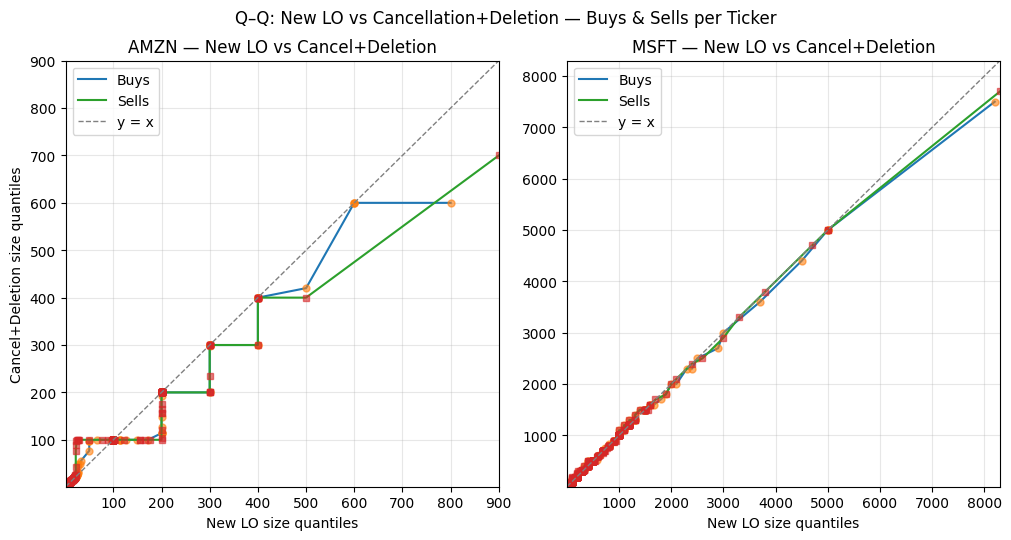

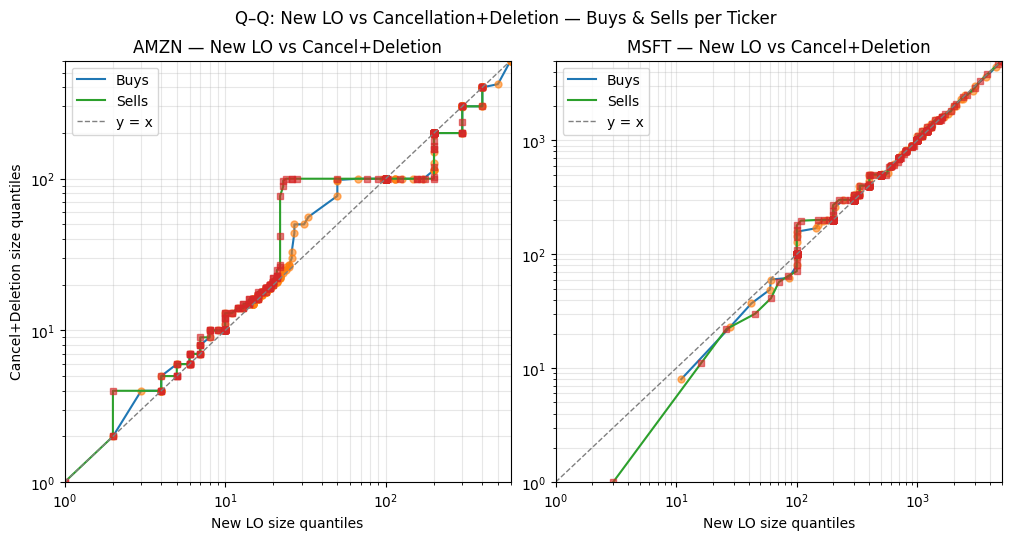

In [15]:
display(Markdown("### Most orders are cancelled or deleted"))
plot_order_volume_qq(msgBooks)
plot_order_volume_qq(msgBooks, clip_quantile=0.995, logxy=True)


### Check for trading halts.

----------------------------------------------------------
When trading halts, a message of type '7' is written into the 
'message' file. The corresponding price and trade direction 
are set to '-1' and all other properties are set to '0'. 

Should the resume of quoting be indicated by an additional 
message in NASDAQ's Historical TotalView-ITCH files, another 
message of type '7' with price '0' is added to the 'message' 
file. Again, the trade direction is set to '-1' and all other 
fields are set to '0'.

When trading resumes a message of type '7' and 
price '1' (Trade direction '-1' and all other 
entries '0') is written to the 'message' file. 

For messages 
of type '7', the corresponding order book rows contain a 
duplication of the preceding order book state. The reason 
for the trading halt is not included in the output.

Example: Stylized trading halt messages in 'message' file.				

Halt: 			36023	| 7 | 0 | 0 | -1 | -1
                                    ...
Quoting: 		36323 	| 7 | 0 | 0 | 0  | -1
                                    ...
Resume Trading:		36723   | 7 | 0 | 0 | 1  | -1
                                    ...
The vertical bars indicate the different columns in the message file.


Check on Nasdaq historical trading halts http://www.nasdaqtrader.com/Trader.aspx?id=TradeHalts# and reason for halts http://www.nasdaqtrader.com/Trader.aspx?id=TradeHaltCodes

NYSE https://www.nyse.com/trade-halt-current

In [16]:
# Check for trading halts

def check_for_halts(theMessageBookFiltered):
    """Note: As the rows of the message and orderbook file correspond to each other, the time index of
    the message file can also be used to 'cut' the orderbook file."""

    tradingHaltIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.Price == -1) & (theMessageBookFiltered.TradeDirection == -1)]

    tradeQuoteIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.Price == 0)& (theMessageBookFiltered.TradeDirection == -1)]

    tradeResumeIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.Price == 1)& (theMessageBookFiltered.TradeDirection == -1)]

    if (len(tradingHaltIdx) == 0 | len(tradeQuoteIdx) == 0  | len(tradeResumeIdx) == 0):
        print("No trading halts detected.")

    if(len(tradingHaltIdx) != 0):
        print("Data contains trading halt! at time stamp(s): "); print(list(tradingHaltIdx))

    if(len(tradeQuoteIdx) != 0):
        print(" Data contains quoting message! at time stamp(s)"); print(list(tradeQuoteIdx)) 

    if(len(tradeResumeIdx) != 0):
        print(" Data resumes trading! at time stamp(s) "); print(list(tradeResumeIdx))

In [17]:
check_for_halts(msgBooks["AMZN"])
check_for_halts(msgBooks["MSFT"])

No trading halts detected.
No trading halts detected.


## 4. Plot - Number of Executions and Trade Volume by Interval
_____________________________________________________________________________
              
Note: Difference between trades and executions

   The LOBSTER output records limit order executions
   and not what one might intuitively consider trades (market orders).

   Imagine a volume of 1000 is posted at the best ask
   price. Then, an incoming market buy order of
   volume 1000 is executed against the quote.

   The LOBSTER output of this trade depends on the
   composition of the volume at the best ask price.
   Take the following two scenarios with the best ask
 	 volume consisting of ...
   	(a) 1 sell limit order with volume 1000
   	(b) 5 sell limit orders with volume 200 each
      	(ordered according to time of submission)

    The LOBSTER output for case ...
      (a) shows one execution of volume 1000. If the
          incoming market order is matched with one
          standing limit order, execution and trade
          coincide.
      (b) shows 5 executions of volume 200 each with the
          same time stamp. The incoming order is matched
          with 5 standing limit orders and triggers 5
          executions.
          
  --> When the data does not contain errors, these events occur at the same time t (same side of the LOB): by grouping them all together one can reconstruct the volume of the incoming market order. In general though, HF data contains errors and reconstructing MOs from raw data is non-trivial.

  Bottom line:
      LOBSTER records the exact limit orders against
      which incoming market orders are executed. Trade size has to be
      inferred from the executions.

In [18]:
def visible_invisible_plot(inputDataframes,ticker,rolling_seconds=300):
    #to resample we need to set index to a time index
    try:
        assert type(inputDataframes[ticker].index)==pd.core.indexes.datetimes.DatetimeIndex
        
    except AssertionError:
        df=inputDataframes[ticker].set_index(pd.to_datetime(inputDataframes[ticker].Time,unit='s'))
    df=pd.DataFrame(inputDataframes[ticker])
        
    #only select the trade executions (type 4 & 5)
    df=df[df.Type.isin([4,5])]


    #separate out the data of interest into separate columns, use fact that true =1 and  false=0
    df['Visible']=df.Type==4
    df['Visible size']=df['Visible']*df['Size']

    df['Invisible']=-1*(df.Type==5) #-1 multiplier to flip hidden trades on x axis.
    df['Invisible size']=df['Invisible']*df['Size']

    #resample data into rolling_seconds intervals, sum contents of each time bucket.
    resampled_data=df.resample(str(rolling_seconds)+'s',label='right').sum()


    #create a subplot with two axes which shares the x -time axis
    fig,axs=plt.subplots(1,2,sharex=True,figsize=(12,4))

    #using the plotting backend in pandas (pyplot by default)
    resampled_data[['Visible','Invisible']].plot(ax=axs[0],kind='area',color = ('#fc0417','#0c04fc'))
    axs[0].set_ylabel('Number of Executions')

    resampled_data[['Visible size','Invisible size']].plot(ax=axs[1],kind='area',color = ('#fc0417','#0c04fc'))
    _=axs[1].set_ylabel('Quantity of executions')
    
    axs[0].set_title(f'Invisible visible executions for {ticker} over {str(rolling_seconds)} sec rolling period')
    

    return resampled_data

### AMZN

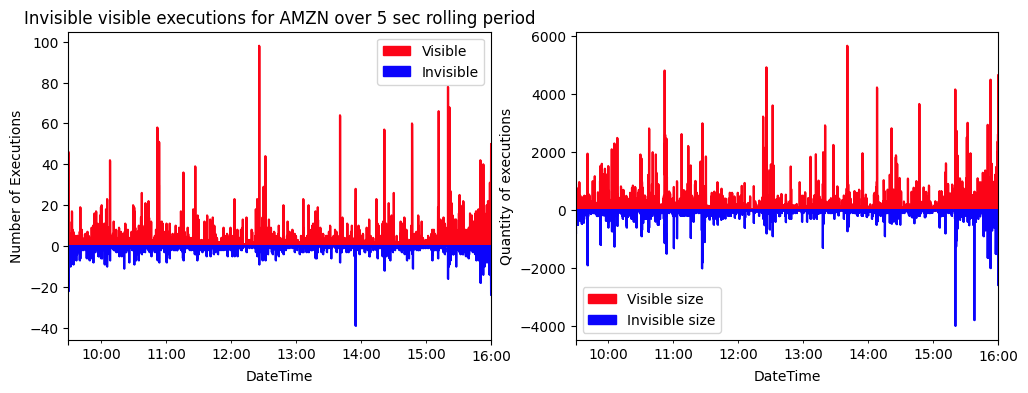

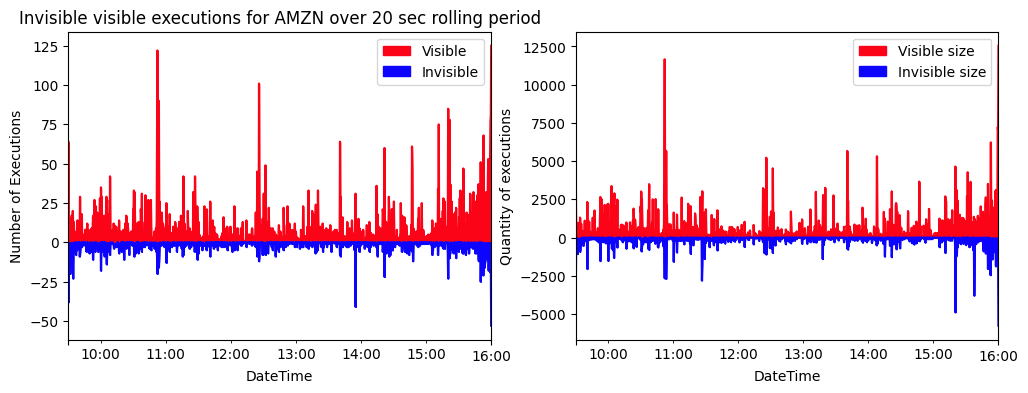

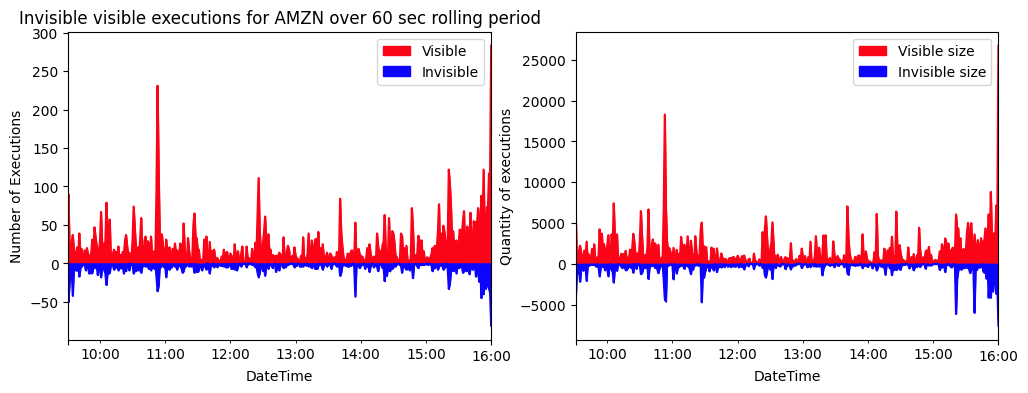

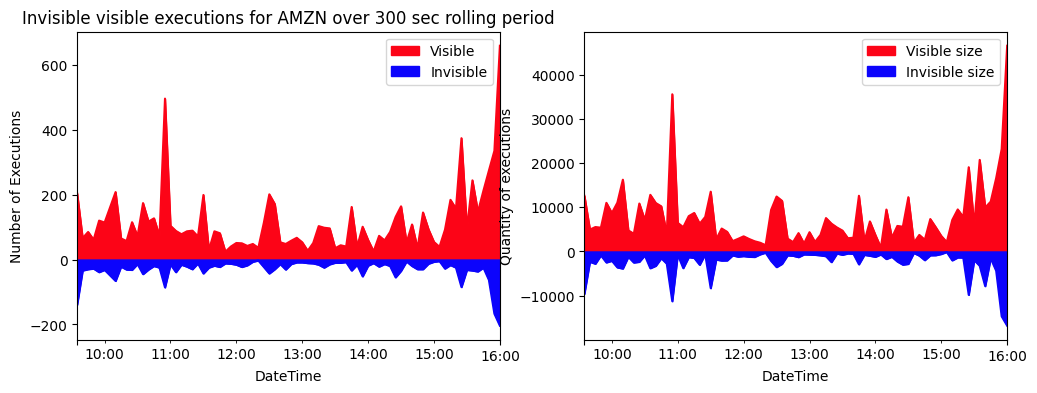

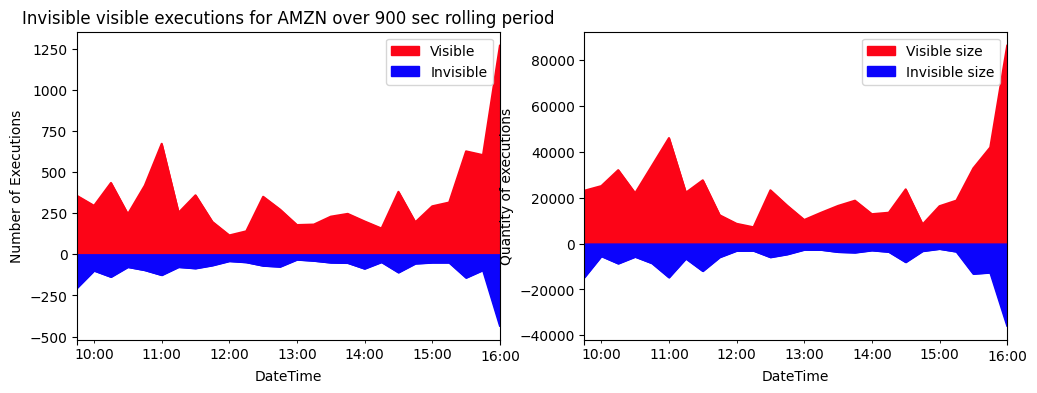

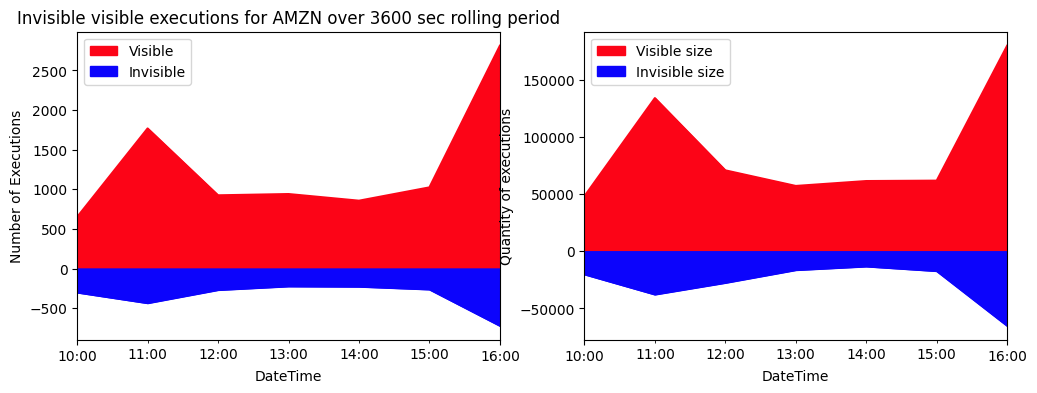

### MSFT

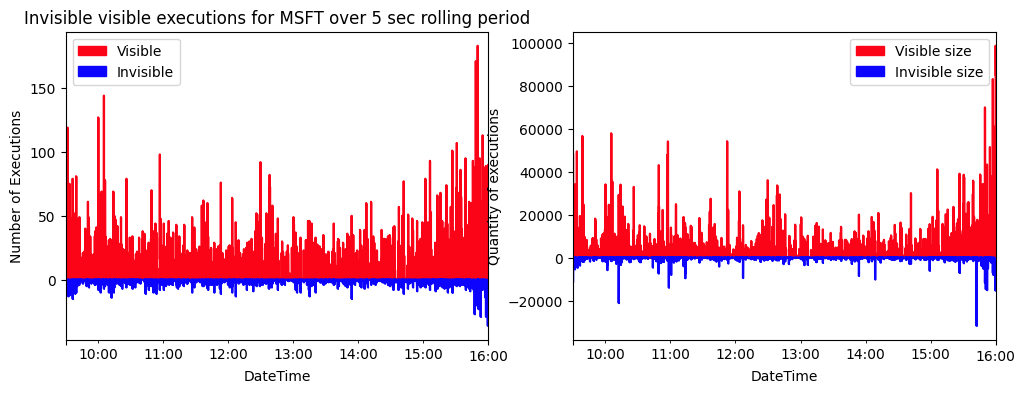

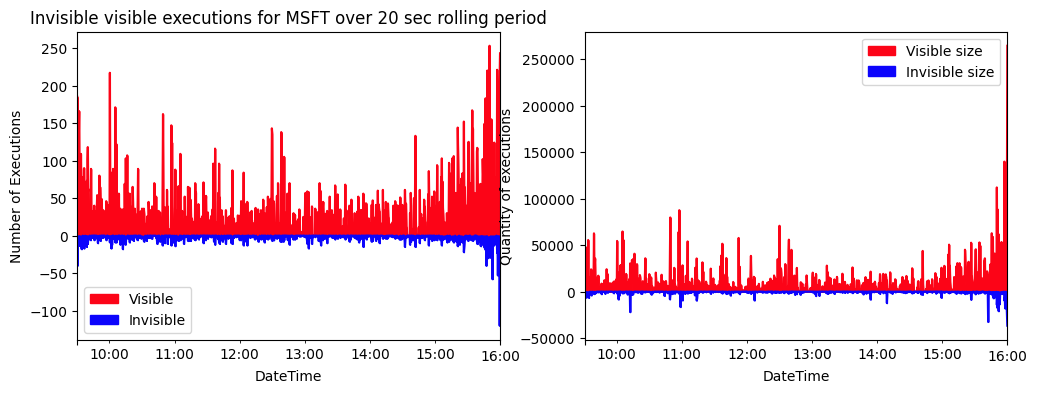

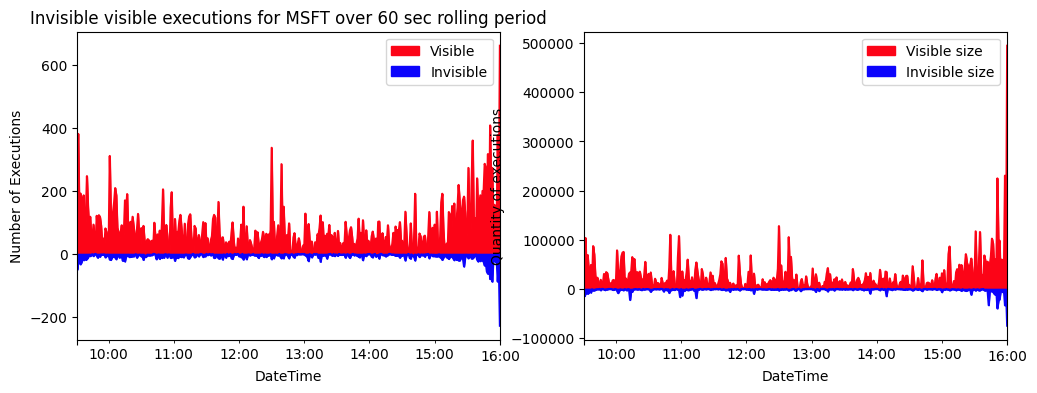

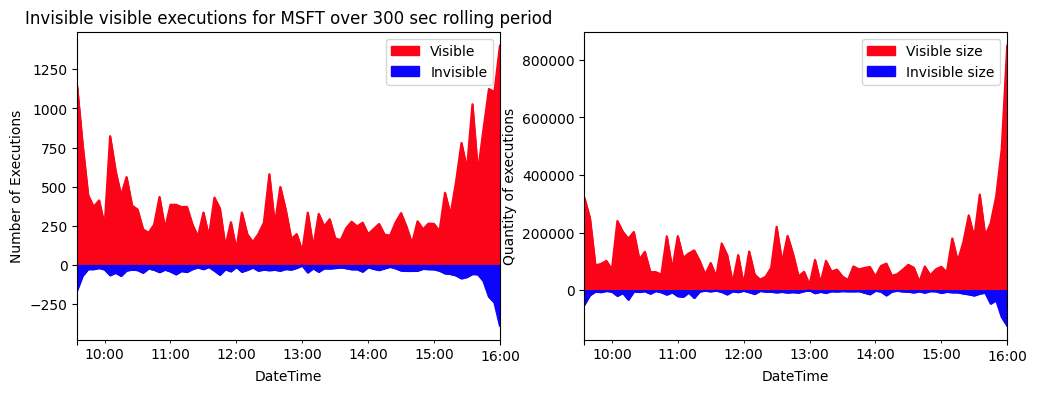

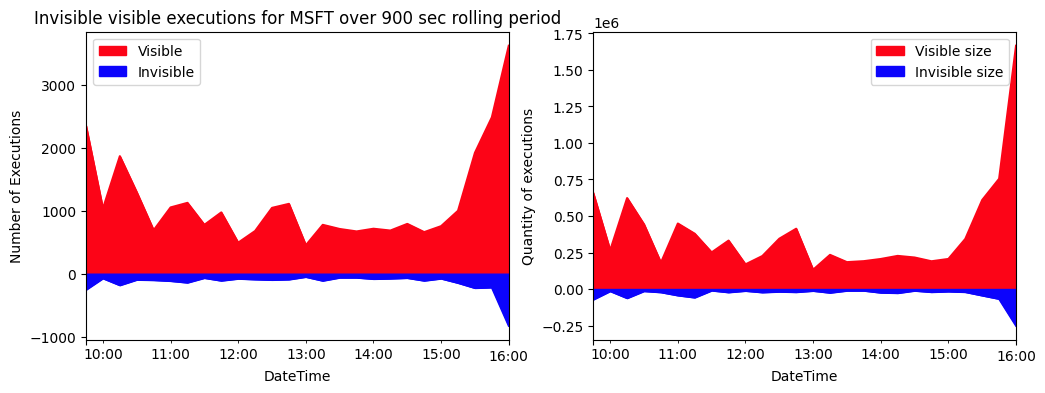

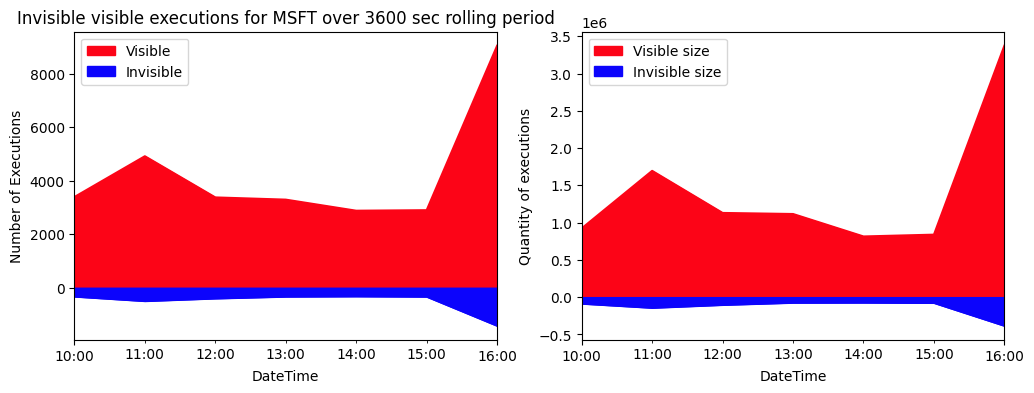

In [19]:
# plot number and size of executions over different time periods

resampled_data = {} # visible_invisible_plot function returns the data, so initiate a dictionary to hold it
intervals = [5, 20, 60, 300, 900, 3600] # seconds

for ticker in tickers:
    resampled_data[ticker] = {}
    display(Markdown(f"### {ticker}"))
    for interval in intervals: # loop over time intervals
        resampled_data[ticker][interval]=visible_invisible_plot(msgBooks, ticker, rolling_seconds=interval)
        plt.show()

### Plot hidden volume as portion of total volume for each stock

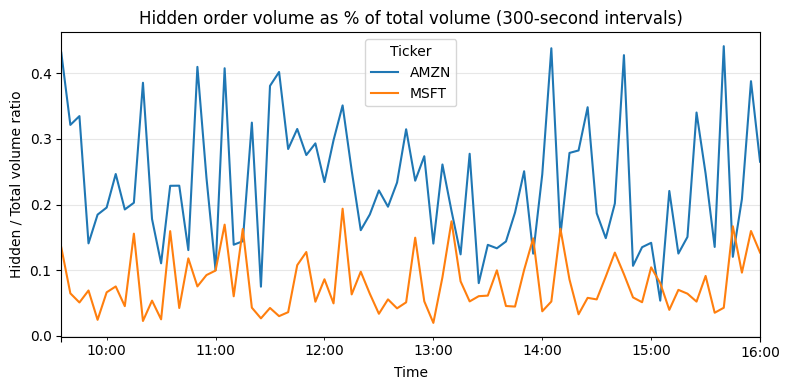

In [20]:
# Hidden order volume as portion of total volume

interval = 300  # seconds

assert interval in intervals, f"Invalid interval: {interval}. Must be one of {intervals}."

# Create a new figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

for ticker in tickers:
    # Retrieve the relevant DataFrame
    df = resampled_data[ticker][interval]

    # Compute hidden volume ratio (% of total volume)
    hidden_ratio = -1 * df["Invisible size"] / df["Size"]

    # Plot it
    hidden_ratio.plot(ax=ax, label=ticker)

# Final plot formatting
ax.legend(title="Ticker")
ax.set_title(f"Hidden order volume as % of total volume ({interval}-second intervals)")
ax.set_xlabel("Time")
ax.set_ylabel("Hidden / Total volume ratio")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Now we are going to look at the order book data.

## Orderbook file information:
----------------------------------------------------------

  - Dimension:    (NumberEvents x (NumberLevels*4))

  - Structure:    Each row:
                  Ask price 1, Ask volume 1, Bid price 1,
                  Bid volume 1, Ask price 2, Ask volume 2,
                  Bid price 2, Bid volume 2, ...

  - Note:         Unoccupied bid (ask) price levels are
                  set to -9999999999 (9999999999) with volume 0.
				      
----------------------------------------------------------

In [21]:
def load_order_book(theMessageBook, ticker="AMZN", nlevels = 10):
    """ Load Order Book File
    Output: a dictionary of four dataframes - asks/bids prices/sizes
    indexed by the time index formed from the messagebook df"""

    # create message file name from ticker
    ob_file = os.path.join(DATA_DIR, f"{ticker}{ORDERBOOK_FILE_TAIL}")
    # Load data
    print(ob_file)

    # form column names
    theNames=[str(col_name)+str(level_no) for level_no in range(1,nlevels+1) for col_name in OB_COL_NAMES]

    # Read orderbook from CSV
    theOrderBook = pd.read_csv(ob_file, names = theNames)

    # filter using time index from the messagebook        
    theOrderBookFiltered = theOrderBook.iloc[theMessageBook.row_index]
    # re-index orderbook
    theOrderBookFiltered=theOrderBookFiltered.set_index(theMessageBook.index)
    
    # Convert prices into dollars
    # Note: LOBSTER stores prices in dollar price times 10000

    #separate the four types of column into a dictionary with key=column type
    data_col_dic={c.strip():[c+str(level_no)  for level_no in range(1,nlevels+1)] for c in OB_COL_NAMES}

    #separate data into four aligned dataframes of the four different types of data with key=data type
    data_dic={c:theOrderBookFiltered[cols] for c,cols in data_col_dic.items()}
      
    return data_dic

## 5. Create a dictionary of Order Books keyed by ticker
### Each value itself a dictionary of Ask Price, Ask Size, Bid Price, Bid Size
Ask size etc is a df of nlevels of the orderbook

In [22]:
# Create a dictionary of order books by calling loader for each ticker in tickers list
orderBooks = {t: load_order_book(msgBooks[t], t) for t in tickers}

/Users/Stephen/Documents/University & Courses/UCL/TA Work/2025/COMP0049/Demos & Code/Lab1 - 17-10-2025/data/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv
/Users/Stephen/Documents/University & Courses/UCL/TA Work/2025/COMP0049/Demos & Code/Lab1 - 17-10-2025/data/MSFT_2012-06-21_34200000_57600000_orderbook_10.csv


In [23]:
# Check what it looks like

print(type(orderBooks))
display(orderBooks["AMZN"].keys())
print(type(orderBooks["MSFT"]["Ask Price"]))
display(orderBooks["MSFT"]["Ask Price"].columns)
display(orderBooks["AMZN"]["Ask Size"].head())
display(orderBooks["MSFT"]["Bid Price"].tail())

<class 'dict'>


dict_keys(['Ask Price', 'Ask Size', 'Bid Price', 'Bid Size'])

<class 'pandas.core.frame.DataFrame'>


Index(['Ask Price 1', 'Ask Price 2', 'Ask Price 3', 'Ask Price 4',
       'Ask Price 5', 'Ask Price 6', 'Ask Price 7', 'Ask Price 8',
       'Ask Price 9', 'Ask Price 10'],
      dtype='object')

,Ask Size 1,Ask Size 2,Ask Size 3,Ask Size 4,Ask Size 5,Ask Size 6,Ask Size 7,Ask Size 8,Ask Size 9,Ask Size 10
DateTime,,,,,,,,,,
2012-06-21 09:30:00.017459617,100,100,220,100,547,100,100,100,100,100
2012-06-21 09:30:00.189607670,100,100,220,100,547,100,100,100,100,100
2012-06-21 09:30:00.189607670,100,20,100,220,100,547,100,100,100,100
2012-06-21 09:30:00.189607670,100,20,100,220,100,547,100,100,100,100
2012-06-21 09:30:00.189607670,100,20,100,233,100,547,100,100,100,100


,Bid Price 1,Bid Price 2,Bid Price 3,Bid Price 4,Bid Price 5,Bid Price 6,Bid Price 7,Bid Price 8,Bid Price 9,Bid Price 10
DateTime,,,,,,,,,,
2012-06-21 15:59:59.861465727,301300,301200,301100,301000,300900,300800,300700,300600,300500,300400
2012-06-21 15:59:59.861566671,301300,301200,301100,301000,300900,300800,300700,300600,300500,300400
2012-06-21 15:59:59.873177404,301300,301200,301100,301000,300900,300800,300700,300600,300500,300400
2012-06-21 15:59:59.907796528,301300,301200,301100,301000,300900,300800,300700,300600,300500,300400
2012-06-21 15:59:59.907796528,301300,301200,301100,301000,300900,300800,300700,300600,300500,300400


The output is a dictionary of dataframes. Each row of this dataset should refer to the orderbook state after a new event has happened. So it should be the same length. Let us check that.

In [24]:
def data_checker(OB_dic,msg_book):

    for k,val in OB_dic.items():
        
        assert val.shape[0]==msg_book.shape[0]
        print("ok!",k,type(val),val.shape)

for ticker in tickers:    
    print(ticker)
    data_checker(orderBooks[ticker],msgBooks[ticker])


AMZN
ok! Ask Price <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Ask Size <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Bid Price <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Bid Size <class 'pandas.core.frame.DataFrame'> (269748, 10)
MSFT
ok! Ask Price <class 'pandas.core.frame.DataFrame'> (668765, 10)
ok! Ask Size <class 'pandas.core.frame.DataFrame'> (668765, 10)
ok! Bid Price <class 'pandas.core.frame.DataFrame'> (668765, 10)
ok! Bid Size <class 'pandas.core.frame.DataFrame'> (668765, 10)


## 6. Event time vs time time

### Event time is expressed as the sequence of events that occur in the limit order book.
Sometimes it is convenient to think about of this as time instead of 'normal time'. 

In [25]:

def plot_events_per_second(books, intervals=[300], event_types=None):
    """
    Plots events per second over different time intervals.

    Parameters
    ----------
    books : dict[str, pd.DataFrame]
        Dictionary mapping ticker -> message DataFrame (must include 'Type' column).
    intervals : list[int]
        Rolling window lengths (seconds).
    event_types : int | list[int] | None
        If given, only include rows with Type in event_types (e.g. 4 or [1,4]).
    """
    def _fmt_secs(s):
        if s < 60:
            return f"{s}s"
        elif s % 3600 == 0:
            return f"{s//3600}h"
        else:
            return f"{s//60}m"

    fig, axes = plt.subplots(1, len(books), figsize=(6 * len(books), 4), sharey=True)
    if len(books) == 1:
        axes = [axes]

    for ax, (ticker, df) in zip(axes, books.items()):
        # --- Filter by event type if specified ---
        if event_types is not None:
            if not isinstance(event_types, (list, tuple, set)):
                event_types = [event_types]
            df = df[df["Type"].isin(event_types)]

        # --- Count events per second ---
        per_sec = df.resample("1s").size()

        # --- Rolling averages for each interval ---
        for k in intervals:
            per_sec.rolling(k).mean().plot(ax=ax, label=_fmt_secs(k),linewidth=0.8, alpha=0.6)

        # --- Formatting ---
        ax.set_title(f"{ticker}: Rolling average of events per second")
        ax.set_xlabel("Time")
        if ax is axes[0]:
            ax.set_ylabel("Events per second")
        ax.grid(alpha=0.3)
        ax.legend(title="Interval")

    fig.autofmt_xdate()
    plt.show()


### All events

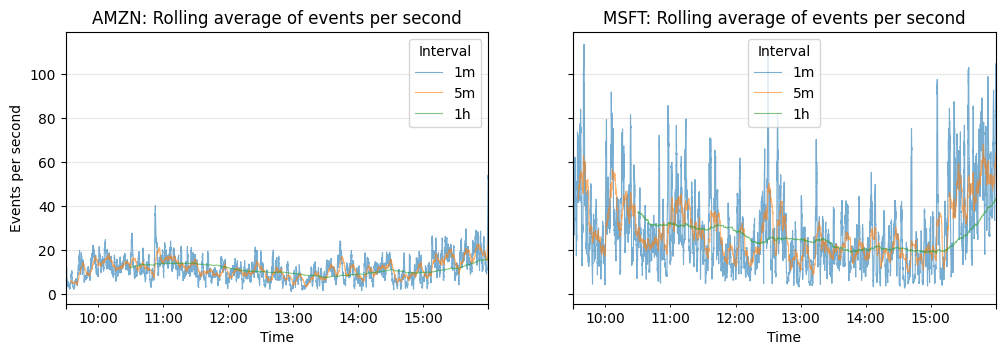

### Execution visible

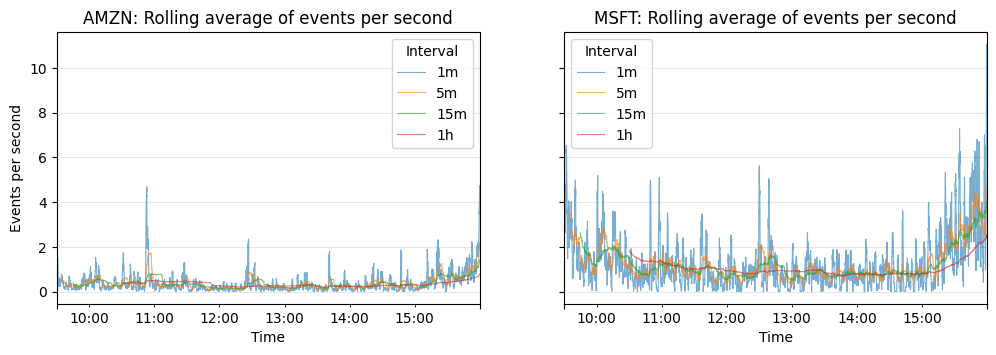

### New LO & Cancel

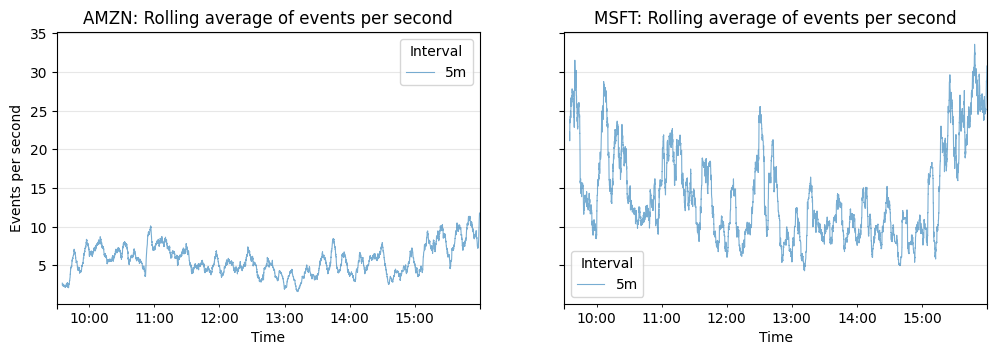

In [26]:
display(Markdown("### All events"))
plot_events_per_second(msgBooks, intervals=[60, 300, 3600])
display(Markdown(f"### {TYPE_MAP[4]}"))
plot_events_per_second(msgBooks, intervals=[60, 300, 900, 3600], event_types=4)
display(Markdown(f"### {TYPE_MAP[1]} & {TYPE_MAP[2]}"))
plot_events_per_second(msgBooks, intervals=[300], event_types=[1, 2])


## 7. Analyse the order book

### Calculate mid-prices and bid-ask spreads - how do they develop through the trading day?

In [27]:
for ticker in tickers:
    ob = orderBooks[ticker]
    ob["Mid"] = (ob["Ask Price"]["Ask Price 1"] + ob["Bid Price"]["Bid Price 1"])/2
    ob["Spread"] = ob["Ask Price"]["Ask Price 1"] - ob["Bid Price"]["Bid Price 1"]
    ob["Ask Gap"] = ob["Ask Price"]["Ask Price 2"] - ob["Ask Price"]["Ask Price 1"]
    ob["Bid Gap"] = ob["Bid Price"]["Bid Price 1"] - ob["Bid Price"]["Bid Price 2"]

### At any point in the day, take a snapshot of the orderbook: calculate execution slippage


In [28]:
def order_book_look(OB_dic,ticker,random_no=None):
    # Note: Pick a random row/event from the order book if not specified
    
    if random_no is None:
        random_no = OB_dic[ticker]['Bid Size'].sample().index[0]
    else:
        #first appearing event after the given time
        random_no=OB_dic[ticker]['Bid Size'][OB_dic[ticker]['Bid Size'].index>random_no].index[0]
      
    time=random_no.strftime('%H:%M:%S:%f')

    #
    # Plot 1 - Snapshot of the Limit Order Book
    #_____________________________________________________________________________

    fig,ax=plt.subplots(1,3,figsize=(12,4)) 

    bid_data=OB_dic[ticker]['Bid Size'].loc[random_no]
    bid_prices=OB_dic[ticker]['Bid Price'].loc[random_no]

    ask_data=OB_dic[ticker]['Ask Size'].loc[random_no]
    ask_prices=OB_dic[ticker]['Ask Price'].loc[random_no]


    ax[0].bar(ask_prices/10000,ask_data,width=0.007, color='#fc1b04', label='Ask')   # Divide price by 10000 to get price in dollars
    ax[0].bar(bid_prices/10000,bid_data,width=0.007,color='#13fc04', label='Bid')

    # Add vertical dotted line at the mid-price
    mid_price = OB_dic[ticker]['Mid'].loc[random_no] / 10000   # scale to dollars
    ax[0].axvline(x=mid_price, color='k', linestyle=':', linewidth=1.5, label='Mid price')
    # text label near the line
    ax[0].text(mid_price*0.99995, ax[0].get_ylim()[1]*0.95, 'Mid', rotation=90, ha='center', va='top', color='k', fontsize=9)

    ax[0].set_ylabel('Quantity')
    ax[0].set_xlabel('Price($)')
    ax[0].set_title(f'Order book at {str(time)} for {ticker}')
    #_____________________________________________________________________________
    #
    # Plot 2 - Relative Depth in the Limit Order Book
    #_____________________________________________________________________________
    # Plot variables
    ax[1].step(range(1,11,1),bid_data.cumsum()/bid_data.sum(),label='Bid',color='#13fc04')
    ax[1].step(range(1,11,1),-1*ask_data.cumsum()/ask_data.sum(),label='Ask',color='#fc1b04')

    ax[1].set_ylim(-1,1)
    ax[1].set_xlim(1,10)
    #ax[1].set_title('Relative Depth in the Limit Order Book for ' + ticker + ' at ' + str(time))
    ax[1].set_ylabel('% Orderbook')
    ax[1].set_xlabel('Level')

    # ============================================================
    # Plot 3 — Concession from mid vs cumulative size
    # ============================================================
    # Compute cumulative quantities
    cum_bid_qty = bid_data.cumsum()
    cum_ask_qty = ask_data.cumsum()

    # Compute concession in price terms (bps from mid)
    bid_concession = (mid_price - bid_prices / 10000) / mid_price * 1e4  # in basis points
    ask_concession = (ask_prices / 10000 - mid_price) / mid_price * 1e4  # in basis points

    # Plot size vs concession
    ax[2].plot(cum_bid_qty, bid_concession, '-o', color='#13fc04', label='Bid side')
    ax[2].plot(cum_ask_qty, ask_concession, '-o', color='#fc1b04', label='Ask side')
    ax[2].set_xlabel('Cumulative size (shares)')
    ax[2].set_ylabel('Concession from mid (bps)')
    ax[2].set_title('Execution cost curve')
    ax[2].legend()
    ax[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return random_no

### AMZN

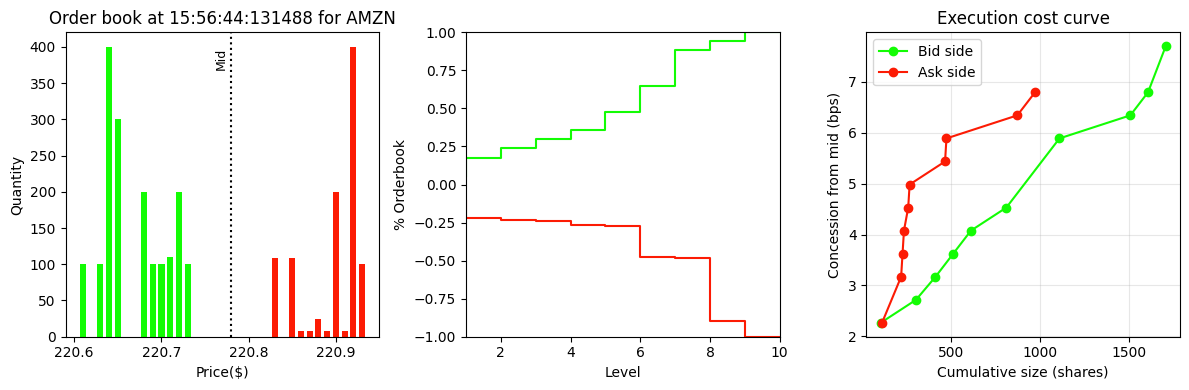

### MSFT

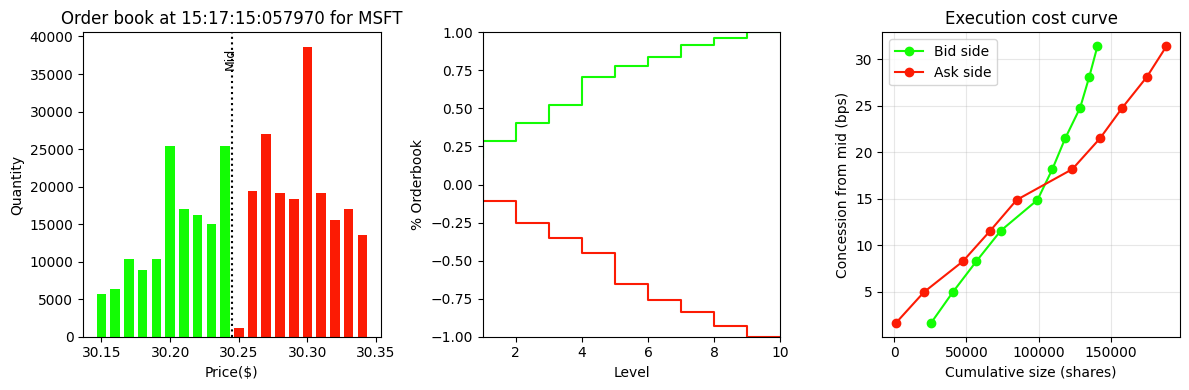

In [29]:
for ticker in tickers:
    display(Markdown(f"### {ticker}"))
    time=order_book_look(orderBooks, ticker)


### Plot Spread through the day

In [30]:
def plot_mid_and_spread(OB_dic, ticker, start=None, end=None, scale_bps=False, rolling_unit=None, spread_events=None):
    """
    Plot mid price and bid-ask spread through time for a given ticker.

    Parameters
    ----------
    OB_dic : dict
        Dictionary containing order book DataFrames for each ticker.
        Must include keys 'Mid', 'Bid Price', and 'Ask Price'.
    ticker : str
        Ticker symbol, e.g. 'AMZN'.
    start, end : optional datetime-like
        Time range to slice (inclusive). If None, use full range.
    scale_bps : bool
        If True, plot spread in basis points instead of absolute dollars.
    """
    mid_series = OB_dic[ticker]['Mid'] / 10000  # convert to dollars
    bid_series = OB_dic[ticker]['Bid Price'].iloc[:, 0] / 10000
    ask_series = OB_dic[ticker]['Ask Price'].iloc[:, 0] / 10000

    # Align indexes and restrict to time range
    df = pd.concat({'Mid': mid_series, 'Bid': bid_series, 'Ask': ask_series}, axis=1).dropna()
    if start is not None:
        df = df[df.index >= pd.to_datetime(start)]
    if end is not None:
        df = df[df.index <= pd.to_datetime(end)]

    # Compute spread
    df['Spread'] = df['Ask'] - df['Bid']
    if scale_bps:
        df['Spread'] = (df['Spread'] / df['Mid']) * 1e4  # convert to basis points

    # Create figure
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    # Plot mid price
    ax1.plot(df.index, df['Mid'], color='steelblue', linewidth=0.7, label='Mid price')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Mid price ($)', color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')

    # Plot spread on secondary y-axis
    ax2.plot(df.index, df['Spread'], color='darkorange', linewidth=0.2, alpha=0.4, label='Spread')
    ax2.set_ylabel('Spread (bps)' if scale_bps else 'Spread ($)', color='darkorange')
    ax2.tick_params(axis='y', labelcolor='darkorange')
    if rolling_unit is not None:
        # Calculate moving average
        ma = df['Spread'].resample(f'{rolling_unit}s', label='right').mean()
        # add moving average to plot
        ax2.plot(ma.index, ma, color='red', linewidth=1.0, label=f'{rolling_unit}s MA')

    if spread_events is not None:
        # Highlight event times on the plot
        ax2.scatter(spread_events[ticker].index, spread_events[ticker]['Spread']/10000, color='blue', s=2, label='Events at Best Quote')

    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    # set tick format
    ax1.xaxis.set_major_locator(MinuteLocator(byminute=range(0, 60, 30)))
    ax1.xaxis.set_major_formatter(DateFormatter("%H:%M"))   # show HH:MM

    ax1.set_title(f"{ticker}: Mid Price and Spread Through Time")
    ax1.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


### AMZN

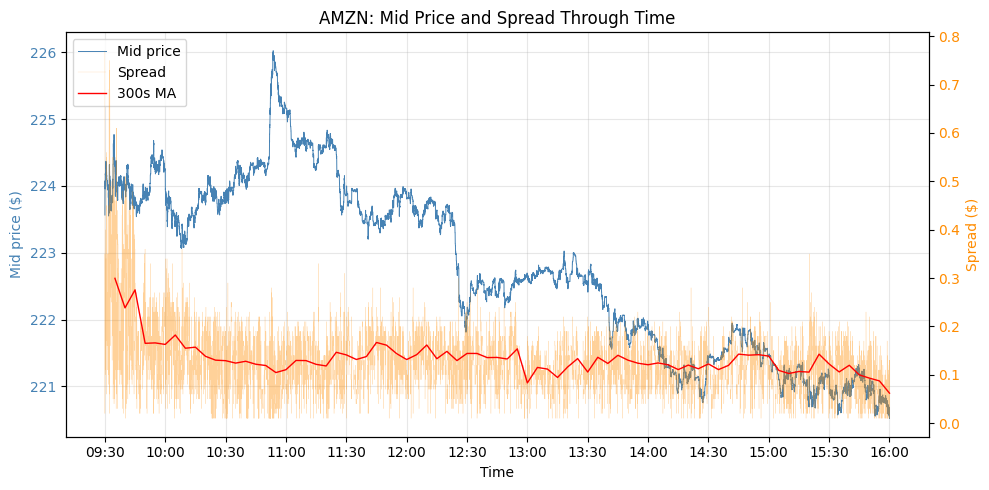

### MSFT

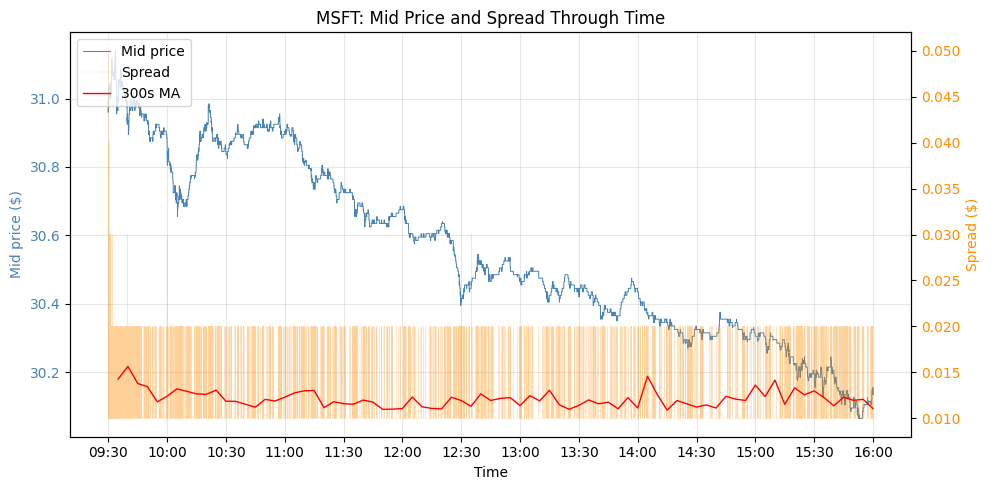

In [31]:
# plot mid prices and spreads

for ticker in tickers:
    display(Markdown(f"### {ticker}"))
    plot_mid_and_spread(orderBooks, ticker, rolling_unit=300)


### Histogram of bid-offer spread

In [32]:

def plot_spread_histograms(OB_dic, tickers=None, levels=(1,2,3),
                                  bins=50, scale_bps=False, clip_quantile=None,
                                  sharey=True, figsize_scale=5):
    """
    Overlaid histograms of bid–ask spread at given depth levels (e.g. L1/L2/L3),
    side-by-side per ticker.

    levels are 1-based (1=best, 2=second, 3=third) etc
    """
    tickers = tickers or list(OB_dic.keys())

    # Build per-ticker dict: level -> spread series
    spreads = {}
    for t in tickers:
        spreads[t] = {}
        bid_df = OB_dic[t]['Bid Price'] / 10000.0
        ask_df = OB_dic[t]['Ask Price'] / 10000.0

        max_cols = min(bid_df.shape[1], ask_df.shape[1])
        for L in levels:
            idx = L - 1  # 0-based
            if idx >= max_cols:
                continue  # skip if level not available
            bid = bid_df.iloc[:, idx]
            ask = ask_df.iloc[:, idx]
            spread = (ask - bid).dropna()

            if scale_bps:
                mid = ((ask + bid) / 2.0).reindex(spread.index)
                spread = ((spread / mid) * 1e4).dropna()  # bps

            if clip_quantile is not None and len(spread):
                cap = float(np.nanquantile(spread, clip_quantile))
                spread = spread.clip(upper=cap)

            spreads[t][L] = spread

    # Common x-range across all tickers/levels
    all_vals = np.concatenate([s.values
                               for d in spreads.values() for s in d.values()
                               if len(s)])
    if len(all_vals) == 0:
        print("No spread data to plot.")
        return
    xmin, xmax = float(np.nanmin(all_vals)), float(np.nanmax(all_vals))
    if not np.isfinite(xmin) or not np.isfinite(xmax) or xmax <= xmin:
        xmin, xmax = 0.0, xmin + 1.0

    # Plot
    fig, axes = plt.subplots(1, len(tickers), figsize=(figsize_scale * len(tickers), 4), sharey=sharey, constrained_layout=True)
    if len(tickers) == 1:
        axes = [axes]

    # color/label per level (cycles if more levels)
    level_labels = {1: "L1", 2: "L2", 3: "L3"}
    for ax, t in zip(axes, tickers):
        have_any = False
        for i, L in enumerate(levels):
            s = spreads[t].get(L, pd.Series(dtype=float))
            if len(s) == 0:
                continue
            have_any = True
            ax.hist(s, bins=bins, range=(xmin, xmax), alpha=0.6, label=level_labels.get(L, f"L{L}"))
        ax.set_title(t if have_any else f"{t} — no data")
        ax.set_xlabel("Spread (bps)" if scale_bps else "Spread ($)")
        if ax is axes[0]:
            ax.set_ylabel("Frequency")
        ax.grid(alpha=0.3)
        ax.legend(title="Depth")

    unit = "bps" if scale_bps else "$"
    tail = f" (clipped ≤ {clip_quantile*100:.1f}th)" if clip_quantile else ""
    plt.suptitle(f"Bid–Ask Spread Histograms by Depth (L1/L2/L3) [{unit}]{tail}", y=1.05, fontsize=12)
    plt.show()


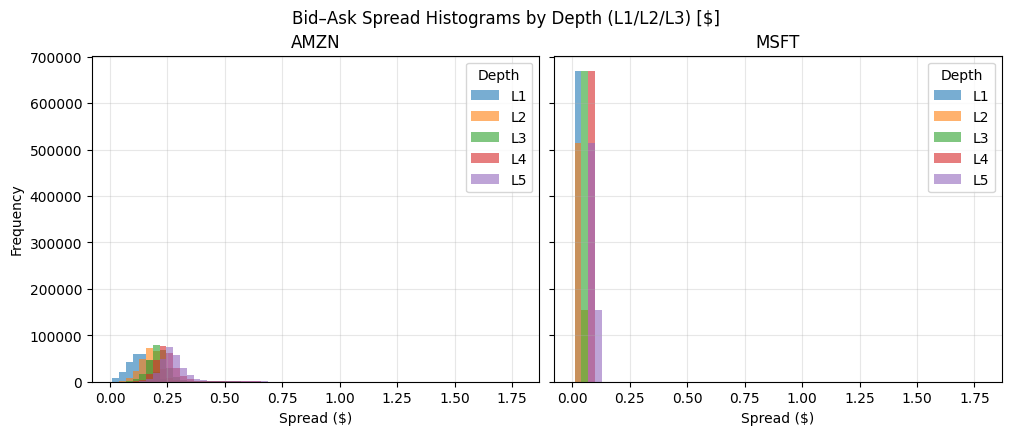

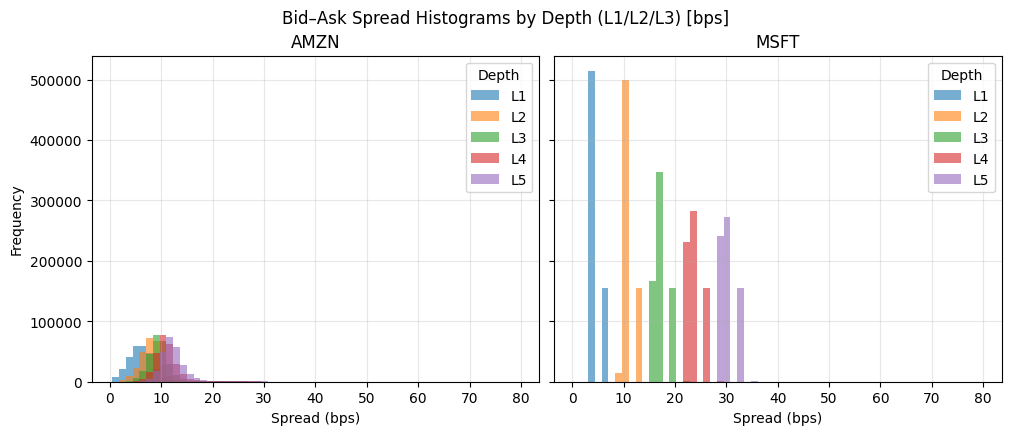

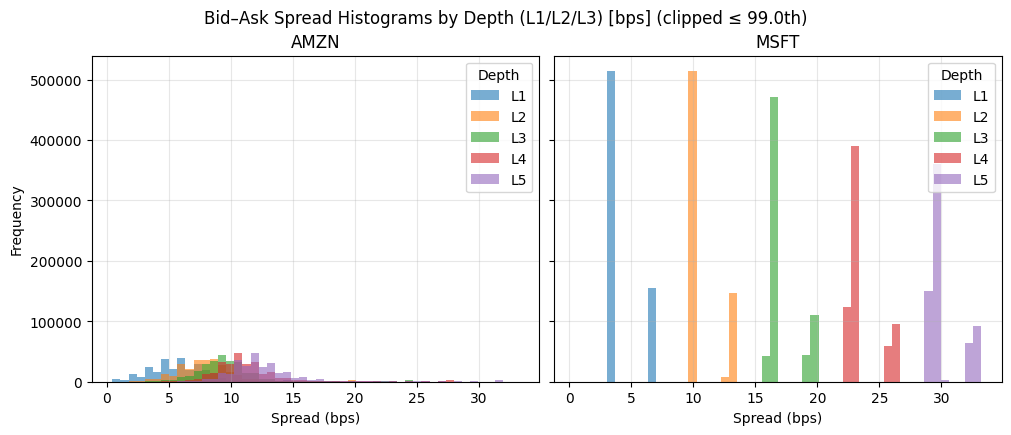

In [33]:
plot_spread_histograms(orderBooks, tickers=["AMZN", "MSFT"], bins=60, levels=(1,2,3,4,5))                 # dollars
plot_spread_histograms(orderBooks, tickers=["AMZN", "MSFT"], bins=60, levels=(1,2,3,4,5), scale_bps=True) # bps
plot_spread_histograms(orderBooks, ["AMZN","MSFT"], bins=50, levels=(1,2,3,4,5), scale_bps=True, clip_quantile=0.99)


### The stocks display very different behaviour

## 8. Closer look at best bids and offers

### Identify when the best bid or best ask changes

In [34]:
# Return events for which Bid-Ask Spread changes

def get_spread_events (OB_dic, ticker):

    # Identify times when there is a change in the best ask or bid prices
    ask_changes = OB_dic[ticker]['Ask Price']['Ask Price 1'].diff().fillna(0) != 0
    bid_changes = OB_dic[ticker]['Bid Price']['Bid Price 1'].diff().fillna(0) != 0
    # Combine the events where either ask or bid price changes
    events_at_best_quote = ask_changes | bid_changes

    spread_events = OB_dic[ticker]['Spread'][events_at_best_quote].to_frame(name='Spread')

    print(ticker)
    print(events_at_best_quote.shape)
    print(spread_events.shape)

    return spread_events


AMZN
(269748,)
(27557, 1)
MSFT
(668765,)
(4060, 1)


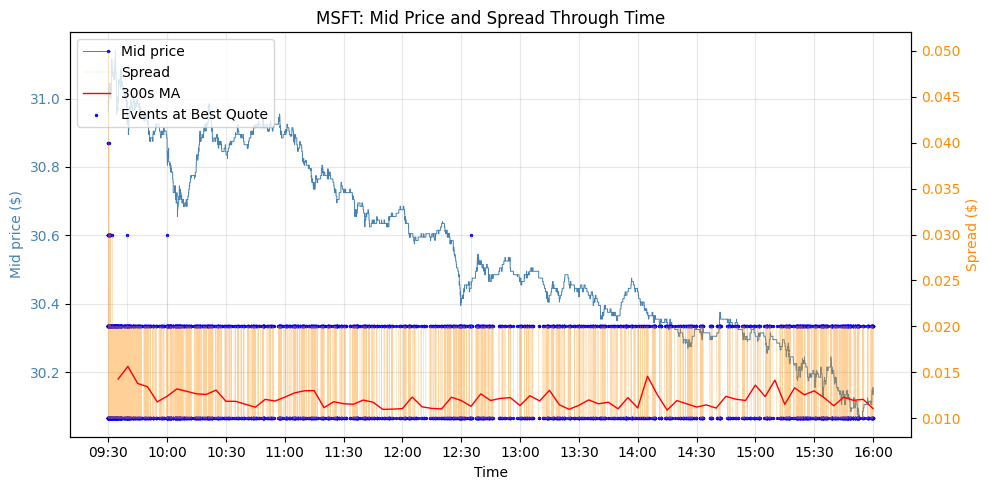

/var/folders/_x/64_mkx9j0r78327hzknhdd4h0000gp/T/ipykernel_42274/4262975477.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Spread at Event")


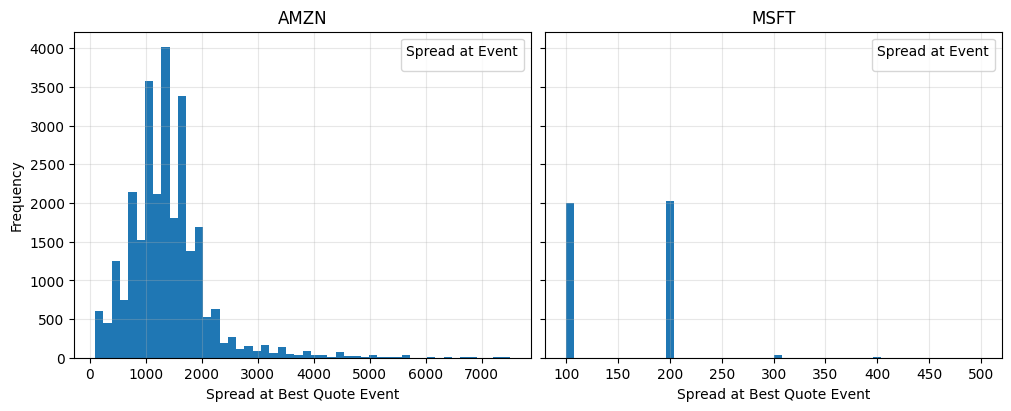

In [35]:
# Plot the spread changing evens
spread_events = {}
for ticker in tickers:
    spread_events[ticker] = get_spread_events (orderBooks, ticker)

plot_mid_and_spread(orderBooks, "MSFT", rolling_unit=300, spread_events=spread_events)


# Histogram of the spread changing events
fig, axes = plt.subplots(1, len(tickers), figsize=(5 * len(tickers), 4), sharey=True, constrained_layout=True)
if len(tickers) == 1:
    axes = [axes]

for ax, t in zip(axes, tickers):
    have_any = False
    s = spread_events[t]
    if len(s) == 0:
        continue
    have_any = True
    ax.hist(s, bins=50)
    ax.set_title(t if have_any else f"{t} — no data")
    ax.set_xlabel("Spread at Best Quote Event")
    if ax is axes[0]:
        ax.set_ylabel("Frequency")
    ax.grid(alpha=0.3)
    ax.legend(title="Spread at Event")

plt.show()

### Plot Size at Best Bid / Ask

In [36]:
# Returns the size at best bid / offer
def size_at_best (OB_dic, ticker):

    depth = pd.DataFrame({
        'Best bid depth': OB_dic[ticker]['Bid Size']['Bid Size 1'],
        'Best ask depth': OB_dic[ticker]['Ask Size']['Ask Size 1']
    })

    return depth

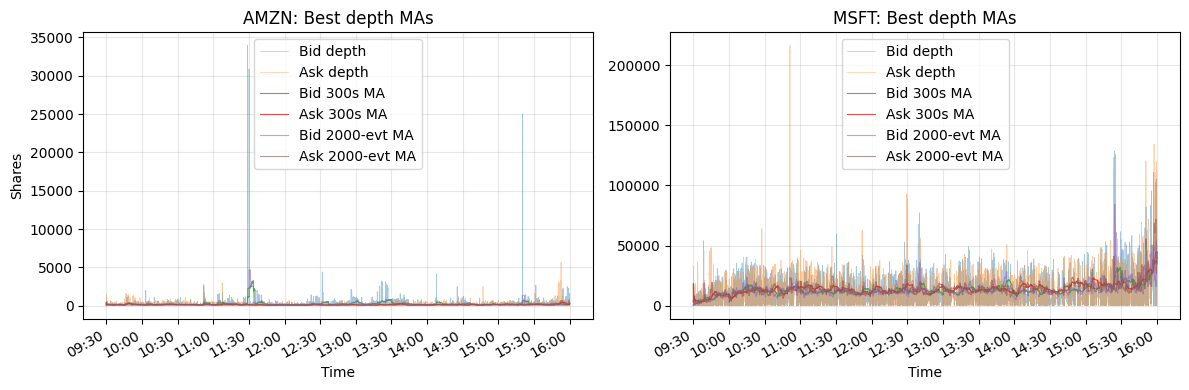

In [37]:
events  = 2000
interval =300
twin    = str(interval)+'s'                    # (b) correct 300s time-based moving average

# Build per-ticker depth frames once
depth = {t: size_at_best(orderBooks, t) for t in tickers}

fig, axes = plt.subplots(1, len(tickers), figsize=(6*len(tickers), 4), sharey=False)
if len(tickers) == 1:
    axes = [axes]

for ax, t in zip(axes, tickers):
    df = depth[t]

    ax.plot(df.index, df['Best bid depth'], linewidth=0.5, alpha=0.4, label='Bid depth')
    ax.plot(df.index, df['Best ask depth'], linewidth=0.5, alpha=0.4, label='Ask depth')

    # (c) 300s time-based MAs (works on irregular timestamps)
    bid_300s = df['Best bid depth'].rolling(twin, min_periods=1).mean()
    ask_300s = df['Best ask depth'].rolling(twin, min_periods=1).mean()

    # (c) 2000-event rolling MAs
    bid_evt  = df['Best bid depth'].rolling(events, min_periods=1).mean()
    ask_evt  = df['Best ask depth'].rolling(events, min_periods=1).mean()

    # (d) thinner lines
    ax.plot(bid_300s.index, bid_300s, linewidth=0.8, alpha=0.8, label='Bid 300s MA')
    ax.plot(ask_300s.index, ask_300s, linewidth=0.8, alpha=0.8, label='Ask 300s MA')
    ax.plot(bid_evt.index,  bid_evt,  linewidth=0.8, alpha=0.6, label='Bid 2000-evt MA')
    ax.plot(ask_evt.index,  ask_evt,  linewidth=0.8, alpha=0.6, label='Ask 2000-evt MA')

    # set tick format
    ax.xaxis.set_major_locator(MinuteLocator(byminute=range(0, 60, 30)))
    ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))   # show HH:MM

    ax.set_title(f"{t}: Best depth MAs")
    if ax is axes[0]:
        ax.set_ylabel("Shares")
    ax.set_xlabel("Time")
    ax.grid(alpha=0.3)
    ax.legend()

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


## 9. Closer look at limit orders

### Calculate net amount of Limit Orders throughout the day

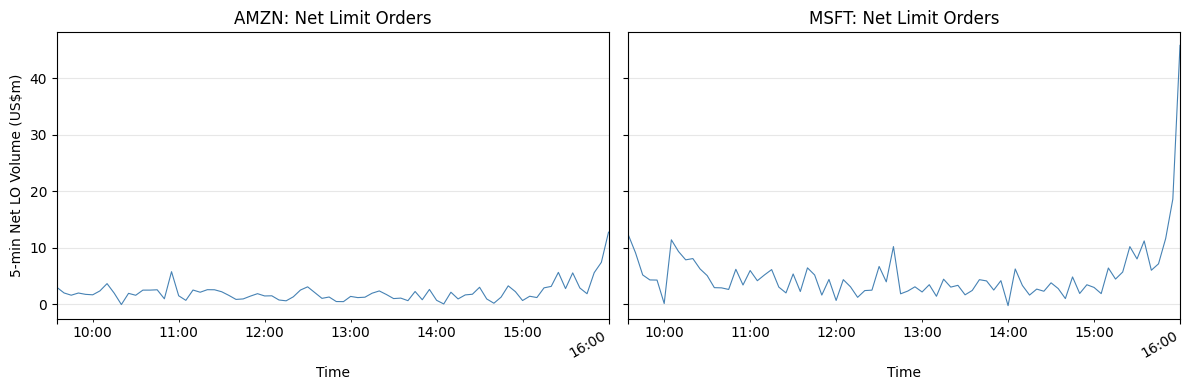

In [38]:

interval=300    
fig, axes = plt.subplots(1, len(tickers), figsize=(6*len(tickers), 4), sharey=True)

if len(tickers) == 1:
    axes = [axes]

for ax, ticker in zip(axes, tickers):
    msg_book = msgBooks[ticker]

    # keep only limit, cancel, delete
    net_lo = msg_book[msg_book.Type.isin([1, 2, 3])].copy()
    net_lo = net_lo.set_index(pd.to_datetime(net_lo.Time, unit='s'))

    # signed volume = + for new LOs, − for cancels/deletes
    net_lo['accrete_deplete'] = net_lo.Type.map({1: 1, 2: -1, 3: -1})
    net_lo['signed_size'] = net_lo['accrete_deplete'] * net_lo['Size']
    net_lo['signed_volume'] = net_lo['signed_size'] * net_lo['Price'] / 10000

    # resample to chosen interval (e.g., 300 s = 5 min)
    net_series = net_lo.signed_volume.resample(f'{interval}s', label='right').sum() / 1e6

    # plot
    net_series.plot(ax=ax, color='steelblue', linewidth=0.8)
    ax.set_title(f"{ticker}: Net Limit Orders")
    ax.set_xlabel("Time")
    if ax is axes[0]:
        ax.set_ylabel(f"{interval//60}-min Net LO Volume (US$m)")
    ax.grid(alpha=0.3)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


### Event rates in the LOB
### Plot the distribution of LO submissions wrt their absolute distance from best.

In [39]:
#get all of the LO submissions

def abs_dist(price,side,best_ask,best_bid):
    #little function to get absolute distance to best depending on order type
    if side==1:
        return best_bid-price
    elif side==-1:
        return price-best_ask



def event_rate(messageBooks,oderBooks,ticker,Type=1):
    msg_book=messageBooks[ticker]
    OB_dic=orderBooks[ticker]

    events=msg_book[msg_book.Type.isin([1])]
    
    #get the raw information we need from the Orderbook (Best bid and ask events)
    Best_state=pd.DataFrame({'Best_bid':OB_dic['Bid Price']['Bid Price 1'],
                             'Best_ask':OB_dic['Ask Price']['Ask Price 1']})
    
    #we want to know the state of the order book before submission of an order
    Best_state['prev_Best_bid']=Best_state.Best_bid.shift(1)
    Best_state['prev_Best_ask']=Best_state.Best_ask.shift(1)
    Best_state.fillna(0,inplace=True)

    #not necessary but this column return true if the best bid/ask has improved
    Best_state['Bid_improved']=Best_state['Best_bid']>Best_state['prev_Best_bid']
    Best_state['Ask_improved']=Best_state['Best_ask']<Best_state['prev_Best_ask']
    
    #prefer concat because we know the rows are aligned. merge may get into trouble for simultaneous events.
    events=pd.concat([events,Best_state.iloc[events.row_index]],sort=False,axis=1)
    
    #apply absolute distance calculation row by row. 
    #This is slow way to do it but 
    events['abs_dist']=events.apply(lambda x: abs_dist(x['Price'],x['TradeDirection'],x['prev_Best_ask'],x['prev_Best_bid']),axis=1 )
    
        
    return events


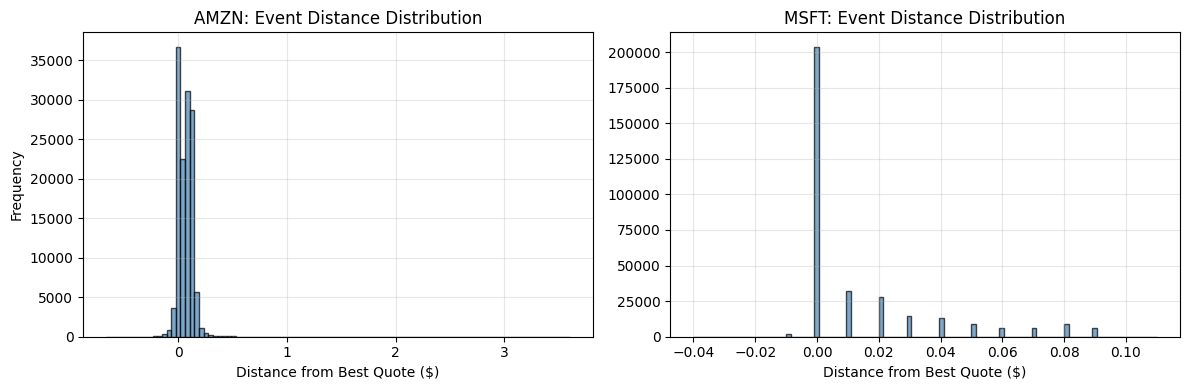

In [40]:
events = {}
for ticker in tickers:
    events[ticker] = event_rate(msgBooks, orderBooks, ticker, 1)



fig, axes = plt.subplots(1, len(tickers), figsize=(6*len(tickers), 4), sharey=False)

if len(tickers) == 1:
    axes = [axes]

for ax, ticker in zip(axes, tickers):
    (events[ticker]['abs_dist'] / 10000).hist(
        bins=100,
        ax=ax,
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    ax.set_title(f"{ticker}: Event Distance Distribution")
    ax.set_xlabel("Distance from Best Quote ($)")
    if ax is axes[0]:
        ax.set_ylabel("Frequency")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
